In [92]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product

In [93]:
def plot_training_curves(train_losses, test_losses, train_mees, test_mees, hyperparams):
    """
    Plot training and test curves for loss and Mean Euclidean Error (MEE).

    Parameters:
    - epoch (int): The total number of training epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_mees (list): List of training MEE values for each epoch.
    - test_mees (list): List of test MEE values for each epoch.
    - hyperparams (list): List of hyperparameters used for the plot.

    Returns:
    None

    Plots four subplots:
    1. Training and test loss curves.
    2. Training and test MEE curves.
    3. Zoomed-in training and test loss curves with y-axis limit [0, 10].
    4. Zoomed-in training and test MEE curves with y-axis limit [0, 10].

    The hyperparameters are used in the plot title to provide additional context.
    """

    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Batch Size={hyperparams[3]},Activation Function={hyperparams[5]}, Layers={hyperparams[6]} Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}, dropout = {hyperparams[7]}')
    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss', color = 'red')
    plt.plot(test_losses, label='Validation Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 2)
    plt.plot(train_mees, label='Training MEE', color='red')
    plt.plot(test_mees, label='Validation MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

    # Loss plots
    plt.subplot(2, 2, 3)
    plt.plot(train_losses, label='Training Loss', color = 'red')
    plt.plot(test_losses, label='Validation Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.ylim(0,5)
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 4)
    plt.plot(train_mees, label='Training MEE', color='red')
    plt.plot(test_mees, label='Validation MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.ylim(0,5)
    plt.legend()

    plt.tight_layout()

    plt.show()

In [94]:
def mean_euclidean_error(tensor1, tensor2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - tensor1: PyTorch tensor of size (N, 3) representing the first set of 3D vectors
    - tensor2: PyTorch tensor of size (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the tensors have the correct shape
    if tensor1.shape[1] != 3 or tensor2.shape[1] != 3 or tensor1.shape[0] != tensor2.shape[0]:
        raise ValueError("Input tensors must be of size (N, 3)")


    # Compute Euclidean distance
    euclidean_distance = torch.norm(tensor1 - tensor2, dim=1)

    # Calculate the mean Euclidean error
    mean_error = torch.mean(euclidean_distance)

    return mean_error.item()

In [95]:
# Define a regression eural network

class RegressorNN(nn.Module):
    def __init__(self, hidden_size, activation_function, num_layers, dropout_prob, input_size=10, output_size=3):
        super(RegressorNN, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, hidden_size)]

        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(activation_function)
            self.layers.append(nn.Dropout(p=dropout_prob))  # Add dropout layer

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Create a Sequential container for the layers
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [96]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

def training_model(x_train, y_train, x_test, y_test, neuron_number,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor, lr_patience, optimiz, num_epochs=1000, plot_curves=False, return_history=False):
    """
    Train the regression model and evaluate it on a test (can also be validation, depending on the context).

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test input data.
    - y_test (torch.Tensor): Test target data.
    - neuron_number (int): Total number of neurons across all layers.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function for the model.
    - layers (int): Number of hidden layers in the model.
    - num_epochs (int, optional): Number of training epochs (default: 1000).
    - plot_curves (bool, optional): Whether to plot training curves (default: False).

    Returns:
    - tuple: Tuple containing the number of epochs, final training loss, final test loss, final training MEE, and final test MEE.

    The function trains a neural network regression model using the specified hyperparameters and evaluates its performance on the test set.
    """

    hidden_size = int(neuron_number/layers)
    #print(hidden_size)
    # Create an instance of the model
    model = RegressorNN(hidden_size=hidden_size, dropout_prob=dropout, activation_function=activation, num_layers=layers)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    if optimiz == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)
    if optimiz == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_coeff)

    # Set the initial learning rate and create a learning rate scheduler
    initial_lr = learning_rate
    #scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Adjust step_size and gamma as needed
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=lr_patience, verbose=True)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_mees, test_mees = [], [], [], []

    # parameters to stop at training convergence
    min_mee = float('inf')
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate mee
        train_mee = mean_euclidean_error(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)

        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test mee
            test_mee = mean_euclidean_error(test_outputs,y_test)
            test_mees.append(test_mee)
            test_losses.append(test_loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}],Learning Rate: {optimizer.param_groups[0]["lr"]}, Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')


        # Check for convergence
        if train_mee < min_mee and abs(train_mee-min_mee)>1e-3:
            patience_counter = 0
            min_mee = train_mee
        else:
            patience_counter += 1

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break


        # Update the learning rate using the scheduler
        scheduler.step(train_mee)

    print(f'N. Epochs = {epoch+1} - Loss (train | test/val )= ({train_loss.item():.4} | {test_loss.item():.4} ) - MEE (train | test/val ) = ({train_mee:.4} | {test_mee:.4} )')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor,lr_patience, num_epochs]
        plot_training_curves(train_losses, test_losses, train_mees, test_mees, hyperparams)

    if return_history:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee, np.array(train_losses), np.array(test_losses), np.array(train_mees), np.array(test_mees)
    else:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee

In [97]:
def reshape_history(N,hist):
    min_len = float('inf')
    for i in range(0,N):
        #print(len(train_losses_hist[i]))
        if len(hist[i]) < min_len:
            min_len = len(hist[i])

    for i in range(0,N):
        hist[i]=hist[i][:min_len]

    return hist

def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         neuron_number,learning_rate, momentum,
                                         bs, reg_coeff, activation,layers, dropout, factor, lr_patience,optimiz, max_num_epochs=1000,
                                         plot_curves=False, N = 5, return_history=False):
    """
    Train the model multiple times with different weight initializations to estimate performance mean and variance.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test input data.
    - y_test (torch.Tensor): Test target data.
    - neuron_number (int): Total number of neurons across all layers.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function for the model.
    - layers (int): Number of hidden layers in the model.
    - num_epochs (int, optional): Number of training epochs (default: 1000).
    - plot_curves (bool, optional): Whether to plot training curves (default: False).
    - N (int, optional): Number of times to train the model with different initializations (default: 5).

    Returns:
    None

    Prints the mean and standard deviation of training and test loss, as well as training and test Mean Euclidean Error (MEE).
    """
    final_train_loss = []
    final_test_loss = []
    final_train_mee = []
    final_test_mee = []
    train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)]
    models = []
    for i in range (0,N):
        #print(f'\n initialization {i+1}/{N}')
        model , num_epochs,train_loss, test_loss, train_mee, test_mee, train_losses_hist[i], test_losses_hist[i], train_mees_hist[i], test_mees_hist[i] = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        neuron_number,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        activation,
                        layers,
                        dropout,
                        factor,
                        lr_patience,
                        optimiz,
                        plot_curves=False,
                        num_epochs=max_num_epochs,
                        return_history=True)


        final_train_loss.append(train_loss)
        final_test_loss.append(test_loss)
        final_train_mee.append(train_mee)
        final_test_mee.append(test_mee)
        models.append(model)

    if plot_curves:
        hyperparams = [int(neuron_number/layers),learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, num_epochs]
        plot_training_curves(train_losses=train_losses_hist[i],test_losses=test_losses_hist[i],train_mees=train_mees_hist[i],test_mees=test_mees_hist[i],hyperparams=hyperparams)

    plt.show()
    print(f'Avg of {N} initializations: Loss (train | test/val )= ({np.mean(final_train_loss):.4} +- {np.std(final_train_loss):.4} | {np.mean(final_test_loss):.4} +- {np.std(final_test_loss):.4})'
          f'- MEE (train | test/val ) = ( {np.mean(final_train_mee):.4} +-  {np.std(final_train_mee):.4} | {np.mean(final_test_mee):.4} +- {np.std(final_test_mee):.4})')


    if return_history:
        train_losses_hist = reshape_history(N,train_losses_hist)
        test_losses_hist = reshape_history(N,test_losses_hist)
        train_mees_hist = reshape_history(N,train_mees_hist)
        test_mees_hist = reshape_history(N,test_mees_hist)
        return models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist
    else:
        return np.mean(final_train_loss), np.mean(final_test_loss), np.mean(final_train_mee), np.mean(final_test_mee)

In [98]:
def perform_grid_search_kfold(neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, activations, layerss, dropouts,factors, lr_patiences, optimiz, k_folds, x, y, plot_curves=False, num_epochs=1000, number_of_init=5):
    """
    Perform grid search with k-fold cross-validation for hyperparameters.

    Parameters:
    - neuron_numbers (list): List of neuron numbers to search.
    - learning_rates (list): List of learning rates to search.
    - momentums (list): List of momentum values to search.
    - batch_sizes (list): List of batch sizes to search.
    - reg_coeffs (list): List of regularization coefficients to search.
    - activations (list): List of activation functions to search.
    - layerss (list): List of numbers of hidden layers to search.
    - k_folds (int): Number of folds for cross-validation.
    - x (numpy.ndarray): Input data.
    - y (numpy.ndarray): Target data.
    - plot_curves (bool, optional): Whether to plot training curves (default: False).
    - num_epochs (int, optional): Number of training epochs (default: 1000).

    Returns:
    - list: List of best hyperparameters.

    The function performs grid search with k-fold cross-validation for Monk classifier hyperparameters and returns the best hyperparameters.
    """

    best_mee = float('inf')
    best_hyperparams = []

    for neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor,lr_patience in product(neuron_numbers,learning_rates,momentums,batch_sizes, reg_coeffs, activations, layerss, dropouts, factors, lr_patiences):
        print(f'activation={activation}; layers={layers}; neuron_number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}; optim = {optimiz}; factor={factor};lr_patience={lr_patience}')

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and MEEs for each epoch
        train_losses, val_losses, train_mees, val_mees = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            train_loss, val_loss, train_mee, val_mee = train_with_different_initializations(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                neuron_number=neuron_number, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, activation=activation, layers=layers,dropout=dropout,factor=factor, lr_patience=lr_patience, optimiz=optimiz ,plot_curves=plot_curves, max_num_epochs=num_epochs, N=number_of_init)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_mees.append(train_mee)
            val_mees.append(val_mee)

        print(f'Final Results: activation={activation}; layers={layers}; neuron number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4} | '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}')

        if np.mean(val_mees) < best_mee:

            best_mee = np.mean(val_mees)
            best_hyperparams = [neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor, lr_patience]

    print(best_hyperparams,'n Best val MEE:',best_mee)
    return best_hyperparams

In [99]:
def plot_mean_std(N,train_hist, test_hist,label):
    mean_tr = np.array(train_hist).mean(axis=0)
    std_tr = np.array(train_hist).std(axis=0)
    mean_te = np.array(test_hist).mean(axis=0)
    std_te = np.array(test_hist).std(axis=0)

    plt.figure(figsize=(9, 8))
    plt.subplot(2,1,1)
    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.legend()

    plt.subplot(2,1,2)

    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.ylim(0,5)
    plt.legend()
    plt.show()


# IMPORT THE DATASET

In [100]:
from sklearn.model_selection import train_test_split
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)



# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PERFORM GRID SEARCH TO FIND BEST HYPERPARAMETERS

activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.5;lr_patience=5


Epoch 01158: reducing learning rate of group 0 to 5.0000e-05..8610 | Test - Epoch [1158/5000], Loss: 0.6930 MEE: 0.9691     
Epoch 01194: reducing learning rate of group 0 to 2.5000e-05.8053 | Test - Epoch [1194/5000], Loss: 0.6418 MEE: 0.9101 
Epoch 01269: reducing learning rate of group 0 to 1.2500e-05.0.7681 | Test - Epoch [1269/5000], Loss: 0.6026 MEE: 0.8847 
Epoch 02087: reducing learning rate of group 0 to 6.2500e-06. 0.5096 | Test - Epoch [2087/5000], Loss: 0.3590 MEE: 0.6946 
Epoch 02116: reducing learning rate of group 0 to 3.1250e-06. 0.5051 | Test - Epoch [2116/5000], Loss: 0.3578 MEE: 0.6921 
Epoch 02209: reducing learning rate of group 0 to 1.5625e-06.: 0.4973 | Test - Epoch [2209/5000], Loss: 0.3521 MEE: 0.6840 
Epoch 02215: reducing learning rate of group 0 to 7.8125e-07.E: 0.4971 | Test - Epoch [2215/5000], Loss: 0.3520 MEE: 0.6841 
N. Epochs = 2221 - Loss (train | test/val )= (0.3286 | 0.3523 ) - MEE (train | test/val ) = (0.4969 | 0.6841 )3 MEE: 0.6841 


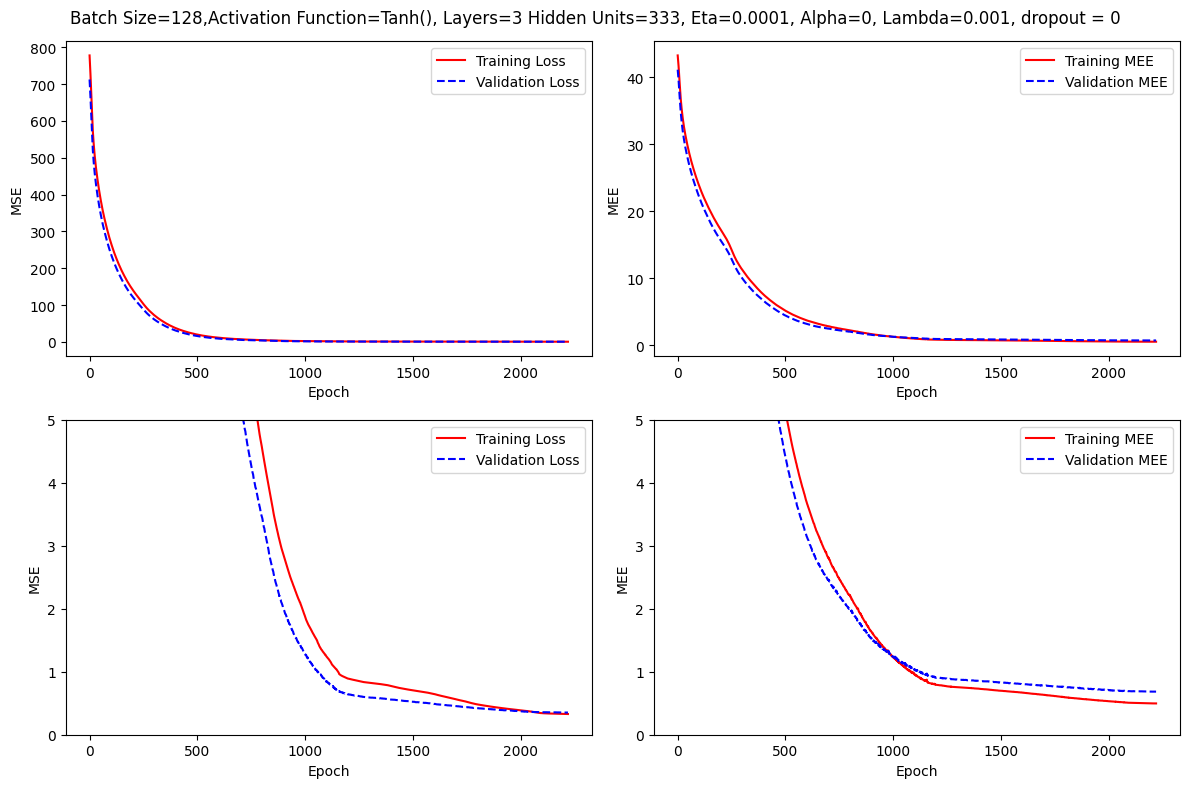

Avg of 1 initializations: Loss (train | test/val )= (0.3286 +- 0.0 | 0.3523 +- 0.0)- MEE (train | test/val ) = ( 0.4969 +-  0.0 | 0.6841 +- 0.0)
Epoch 01100: reducing learning rate of group 0 to 5.0000e-05..9537 | Test - Epoch [1100/5000], Loss: 2.3138 MEE: 1.4028     
Epoch 01446: reducing learning rate of group 0 to 2.5000e-05.5456 | Test - Epoch [1446/5000], Loss: 0.8214 MEE: 0.9297 
Epoch 01468: reducing learning rate of group 0 to 1.2500e-05.0.5340 | Test - Epoch [1468/5000], Loss: 0.8005 MEE: 0.9150 
Epoch 01517: reducing learning rate of group 0 to 6.2500e-06. 0.5203 | Test - Epoch [1517/5000], Loss: 0.7818 MEE: 0.9004 
Epoch 01606: reducing learning rate of group 0 to 3.1250e-06. 0.5103 | Test - Epoch [1606/5000], Loss: 0.7687 MEE: 0.8961 
N. Epochs = 1620 - Loss (train | test/val )= (0.2825 | 0.7664 ) - MEE (train | test/val ) = (0.5091 | 0.8939 ) MEE: 0.8939 


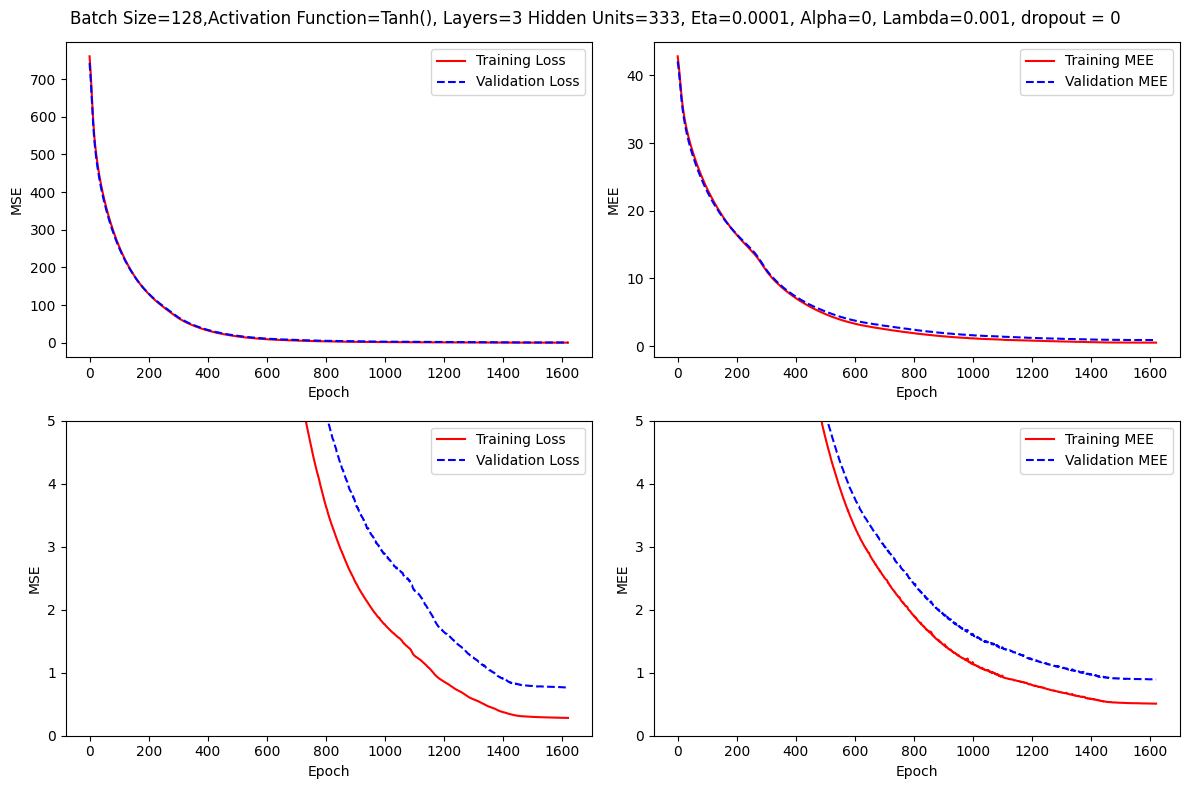

Avg of 1 initializations: Loss (train | test/val )= (0.2825 +- 0.0 | 0.7664 +- 0.0)- MEE (train | test/val ) = ( 0.5091 +-  0.0 | 0.8939 +- 0.0)
Epoch 01007: reducing learning rate of group 0 to 5.0000e-05..0854 | Test - Epoch [1007/5000], Loss: 2.5937 MEE: 1.6210     
Epoch 01116: reducing learning rate of group 0 to 2.5000e-05.9327 | Test - Epoch [1116/5000], Loss: 2.1454 MEE: 1.4553 
Epoch 01661: reducing learning rate of group 0 to 1.2500e-05.0.5617 | Test - Epoch [1661/5000], Loss: 0.9858 MEE: 1.0570 
Epoch 01754: reducing learning rate of group 0 to 6.2500e-06. 0.5331 | Test - Epoch [1754/5000], Loss: 0.9245 MEE: 1.0270 
Epoch 01812: reducing learning rate of group 0 to 3.1250e-06. 0.5226 | Test - Epoch [1812/5000], Loss: 0.9052 MEE: 1.0177 
Epoch 01834: reducing learning rate of group 0 to 1.5625e-06.: 0.5202 | Test - Epoch [1834/5000], Loss: 0.9007 MEE: 1.0160 
Epoch 01843: reducing learning rate of group 0 to 7.8125e-07.E: 0.5199 | Test - Epoch [1843/5000], Loss: 0.9012 MEE: 1

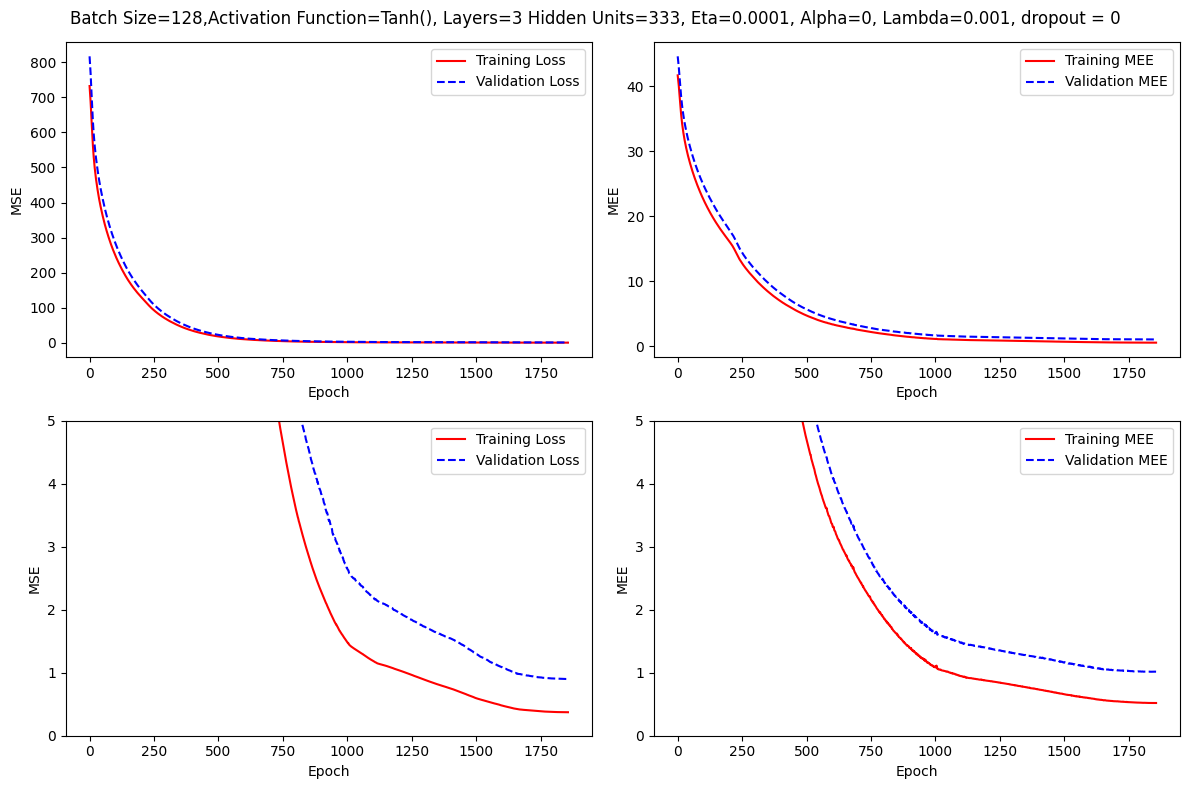

Avg of 1 initializations: Loss (train | test/val )= (0.3729 +- 0.0 | 0.9002 +- 0.0)- MEE (train | test/val ) = ( 0.5195 +-  0.0 | 1.016 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.328 +- 0.0369 | val_loss = 0.673 +- 0.2332train_mee = 0.5085 +- 0.009254 | val_mee = 0.8648 +- 0.1372
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.5;lr_patience=10
Epoch 01387: reducing learning rate of group 0 to 5.0000e-05..5930 | Test - Epoch [1387/5000], Loss: 0.3688 MEE: 0.7380     
Epoch 01756: reducing learning rate of group 0 to 2.5000e-05.4039 | Test - Epoch [1756/5000], Loss: 0.2704 MEE: 0.6251 
Epoch 02053: reducing learning rate of group 0 to 1.2500e-05.0.3489 | Test - Epoch [2053/5000], Loss: 0.2487 MEE: 0.5950 
Epoch 02071: reducing learning rate of group 0 to 6.2500e-06. 0.3446 | Test - Epoch [2071/5000], Loss: 0

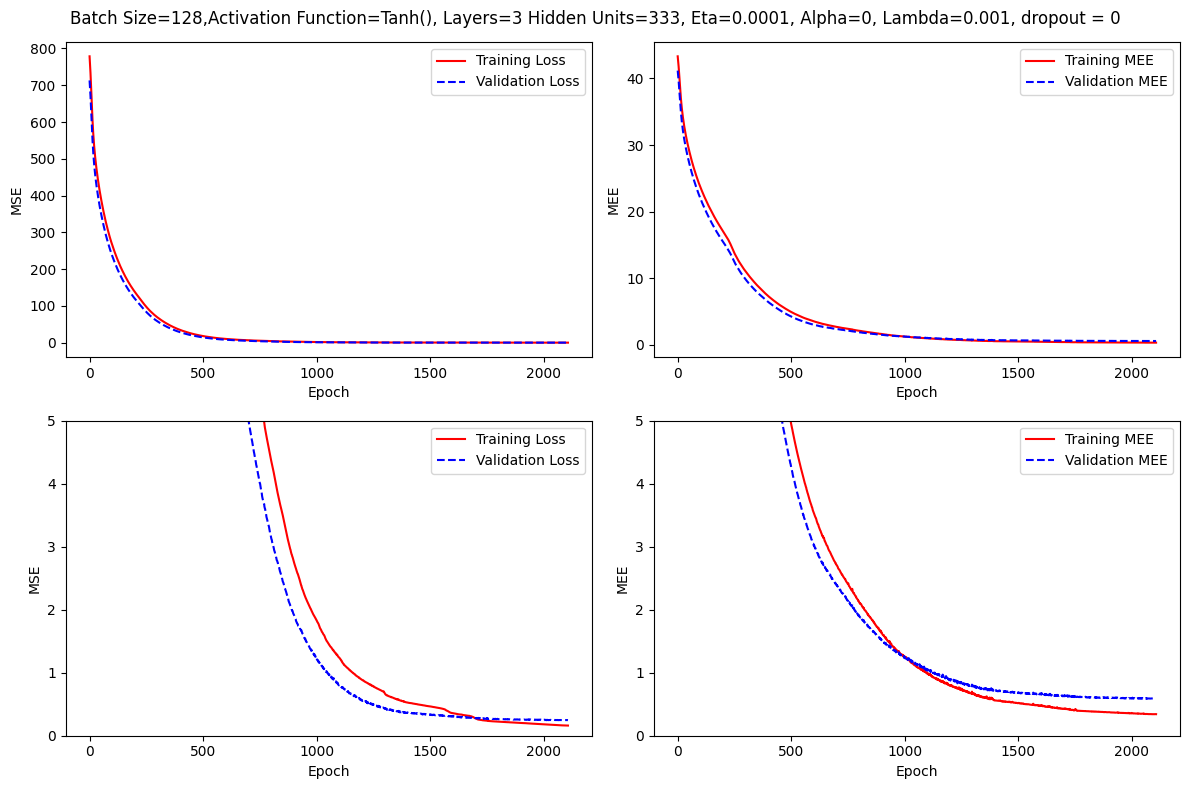

Avg of 1 initializations: Loss (train | test/val )= (0.1614 +- 0.0 | 0.2479 +- 0.0)- MEE (train | test/val ) = ( 0.3424 +-  0.0 | 0.5885 +- 0.0)
Epoch 01443: reducing learning rate of group 0 to 5.0000e-05..4446 | Test - Epoch [1443/5000], Loss: 0.8049 MEE: 0.9225     
Epoch 01525: reducing learning rate of group 0 to 2.5000e-05.4038 | Test - Epoch [1525/5000], Loss: 0.7255 MEE: 0.8761 
Epoch 01655: reducing learning rate of group 0 to 1.2500e-05.0.3777 | Test - Epoch [1655/5000], Loss: 0.6837 MEE: 0.8524 
N. Epochs = 1756 - Loss (train | test/val )= (0.1445 | 0.6593 ) - MEE (train | test/val ) = (0.3665 | 0.8421 )MEE: 0.8421 


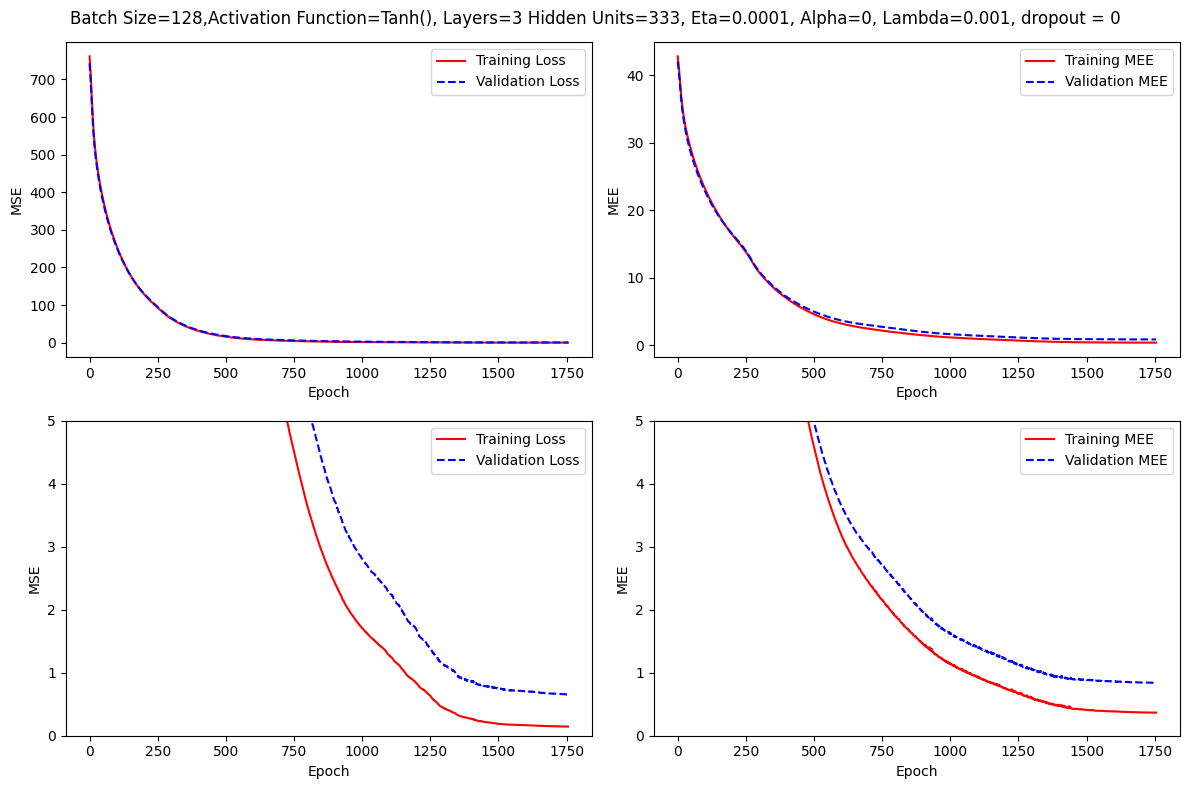

Avg of 1 initializations: Loss (train | test/val )= (0.1445 +- 0.0 | 0.6593 +- 0.0)- MEE (train | test/val ) = ( 0.3665 +-  0.0 | 0.8421 +- 0.0)
Epoch 01370: reducing learning rate of group 0 to 5.0000e-05..4722 | Test - Epoch [1370/5000], Loss: 0.8167 MEE: 0.9859     
Epoch 01444: reducing learning rate of group 0 to 2.5000e-05.4432 | Test - Epoch [1444/5000], Loss: 0.7251 MEE: 0.9499 
Epoch 01686: reducing learning rate of group 0 to 1.2500e-05.0.3880 | Test - Epoch [1686/5000], Loss: 0.6265 MEE: 0.8947 
N. Epochs = 1821 - Loss (train | test/val )= (0.1815 | 0.5995 ) - MEE (train | test/val ) = (0.3725 | 0.8782 )MEE: 0.8782 


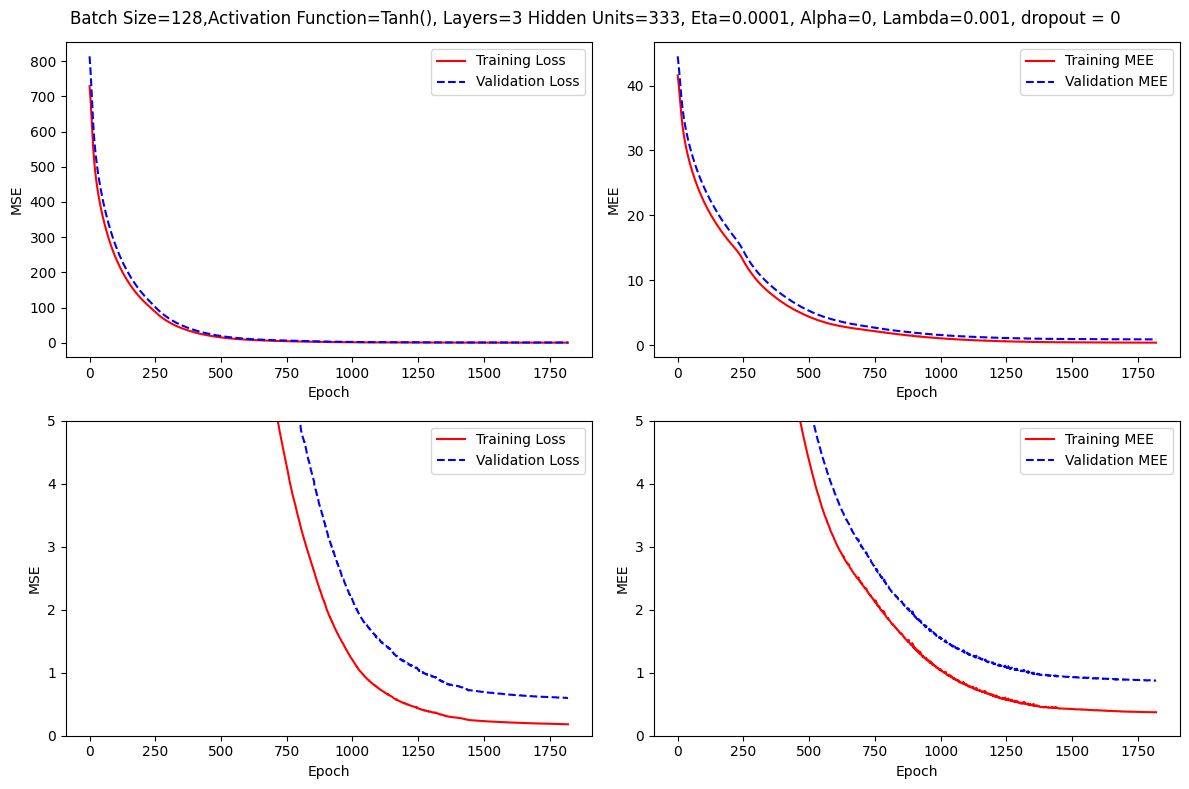

Avg of 1 initializations: Loss (train | test/val )= (0.1815 +- 0.0 | 0.5995 +- 0.0)- MEE (train | test/val ) = ( 0.3725 +-  0.0 | 0.8782 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.1625 +- 0.01512 | val_loss = 0.5022 +- 0.1815train_mee = 0.3605 +- 0.01301 | val_mee = 0.7696 +- 0.1289
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.5;lr_patience=20
N. Epochs = 1681 - Loss (train | test/val )= (0.05777 | 0.2525 ) - MEE (train | test/val ) = (0.3066 | 0.581 )E: 0.5810     


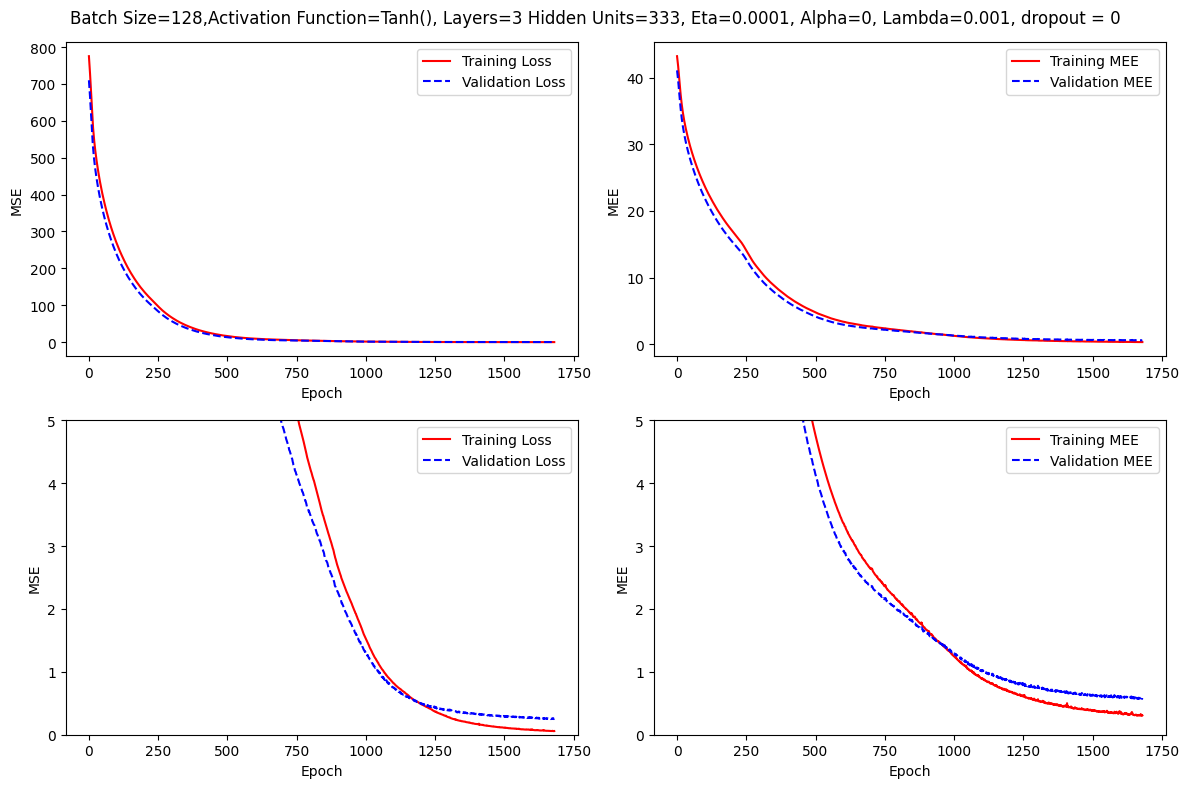

Avg of 1 initializations: Loss (train | test/val )= (0.05777 +- 0.0 | 0.2525 +- 0.0)- MEE (train | test/val ) = ( 0.3066 +-  0.0 | 0.581 +- 0.0)
N. Epochs = 1519 - Loss (train | test/val )= (0.1058 | 0.6958 ) - MEE (train | test/val ) = (0.3698 | 0.9058 )E: 0.9058     


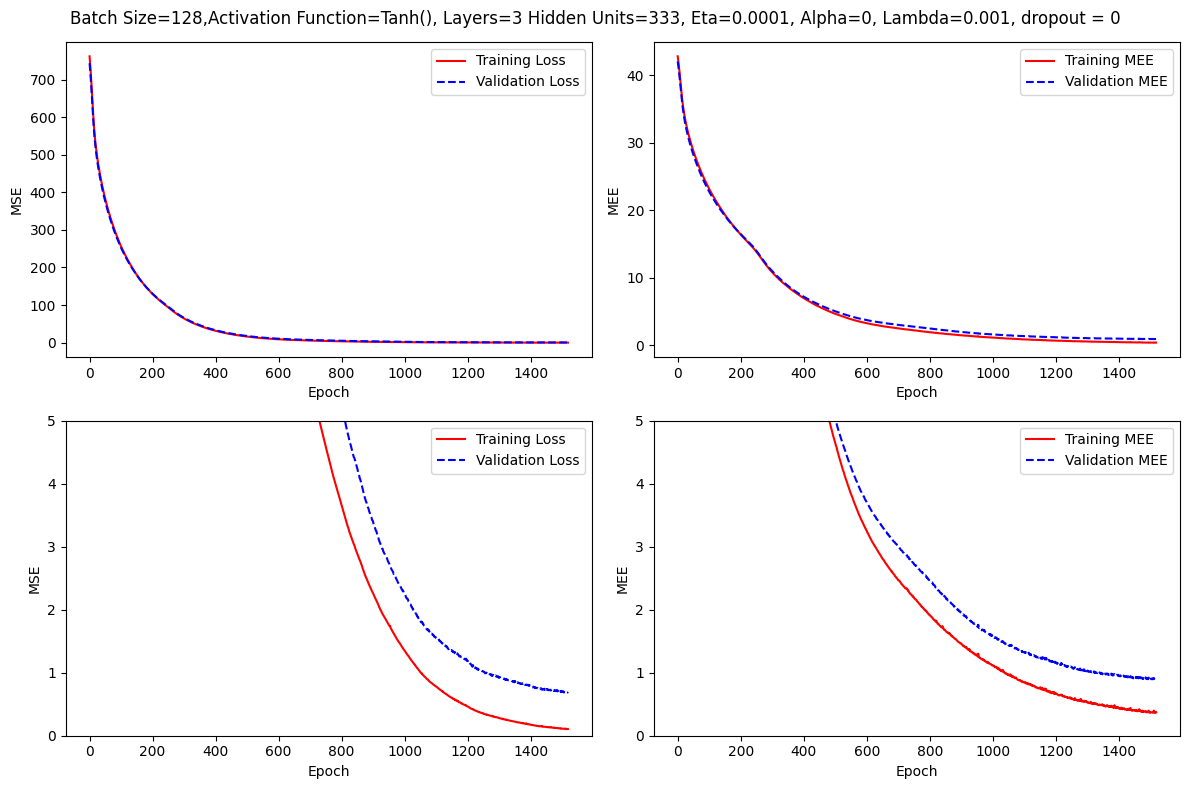

Avg of 1 initializations: Loss (train | test/val )= (0.1058 +- 0.0 | 0.6958 +- 0.0)- MEE (train | test/val ) = ( 0.3698 +-  0.0 | 0.9058 +- 0.0)
N. Epochs = 1648 - Loss (train | test/val )= (0.1139 | 0.4554 ) - MEE (train | test/val ) = (0.3338 | 0.8209 )E: 0.8209     


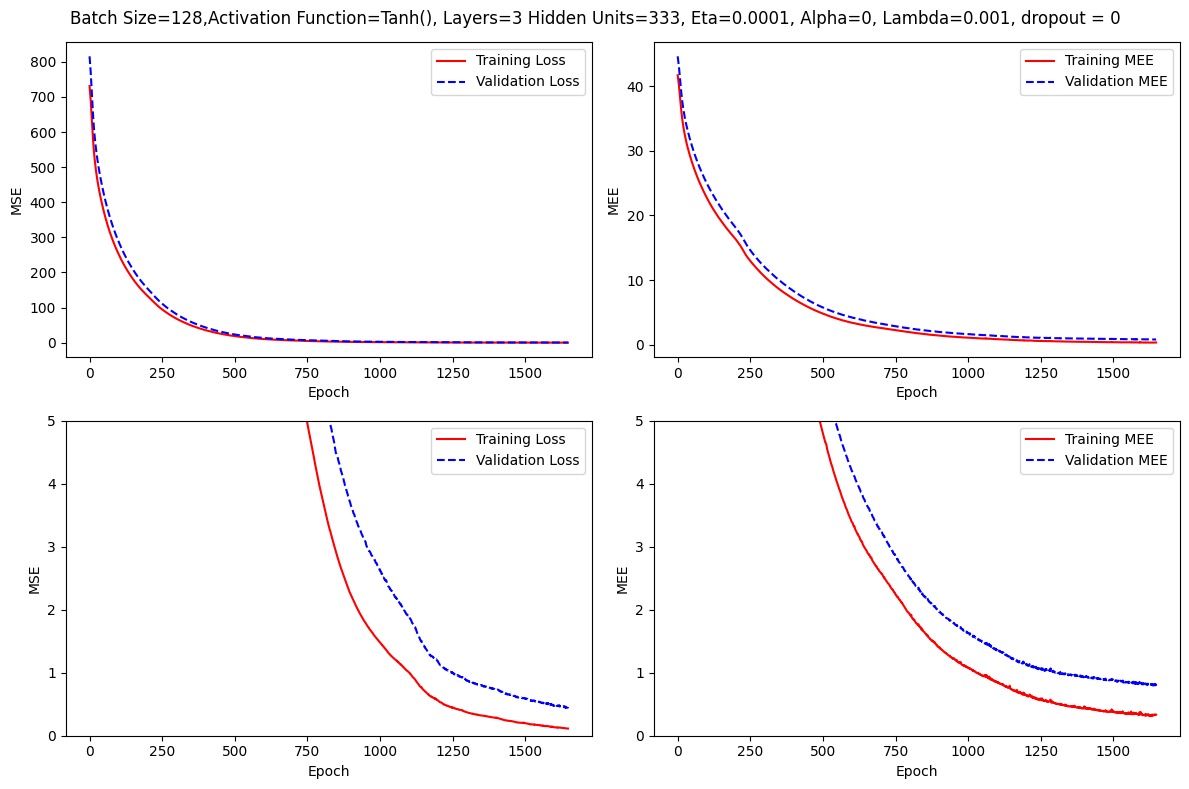

Avg of 1 initializations: Loss (train | test/val )= (0.1139 +- 0.0 | 0.4554 +- 0.0)- MEE (train | test/val ) = ( 0.3338 +-  0.0 | 0.8209 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.09249 +- 0.02477 | val_loss = 0.4679 +- 0.1812train_mee = 0.3367 +- 0.02585 | val_mee = 0.7693 +- 0.1375
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.5;lr_patience=50
N. Epochs = 1683 - Loss (train | test/val )= (0.06174 | 0.2773 ) - MEE (train | test/val ) = (0.3331 | 0.5977 ): 0.5977     


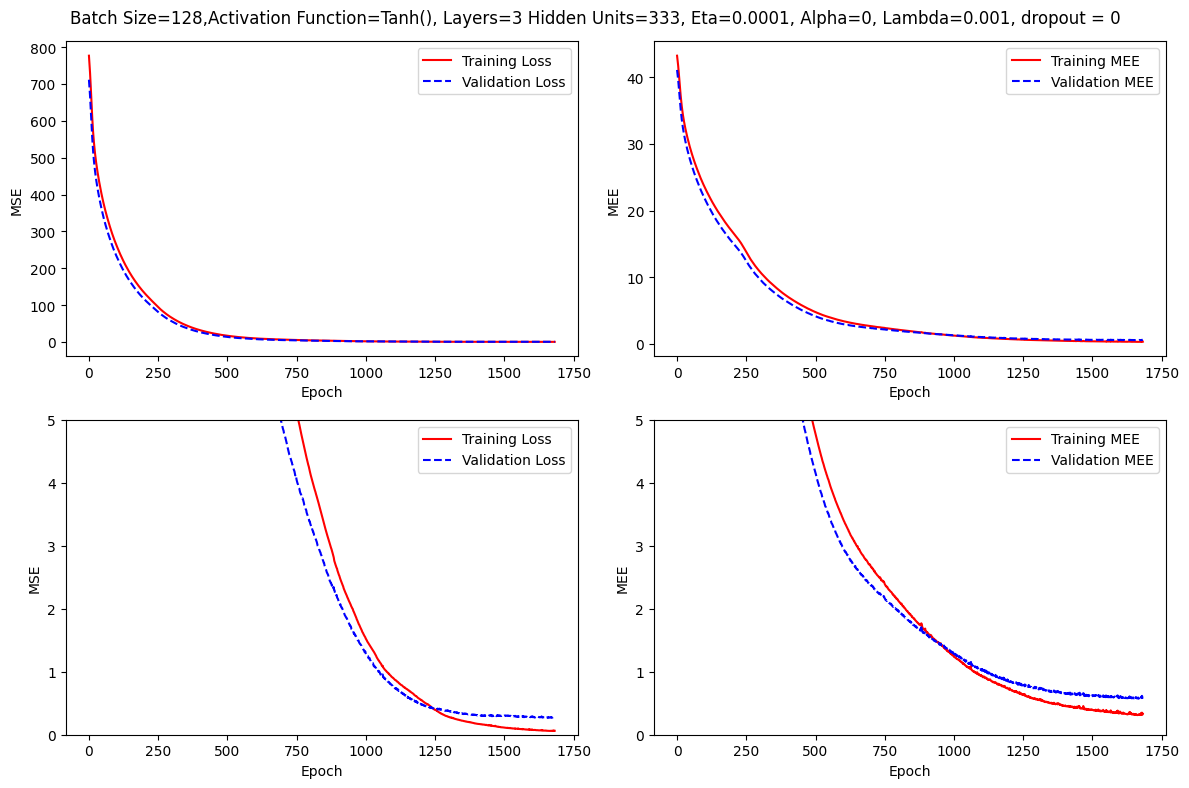

Avg of 1 initializations: Loss (train | test/val )= (0.06174 +- 0.0 | 0.2773 +- 0.0)- MEE (train | test/val ) = ( 0.3331 +-  0.0 | 0.5977 +- 0.0)
N. Epochs = 1620 - Loss (train | test/val )= (0.08341 | 0.6943 ) - MEE (train | test/val ) = (0.3289 | 0.8647 ): 0.8647     


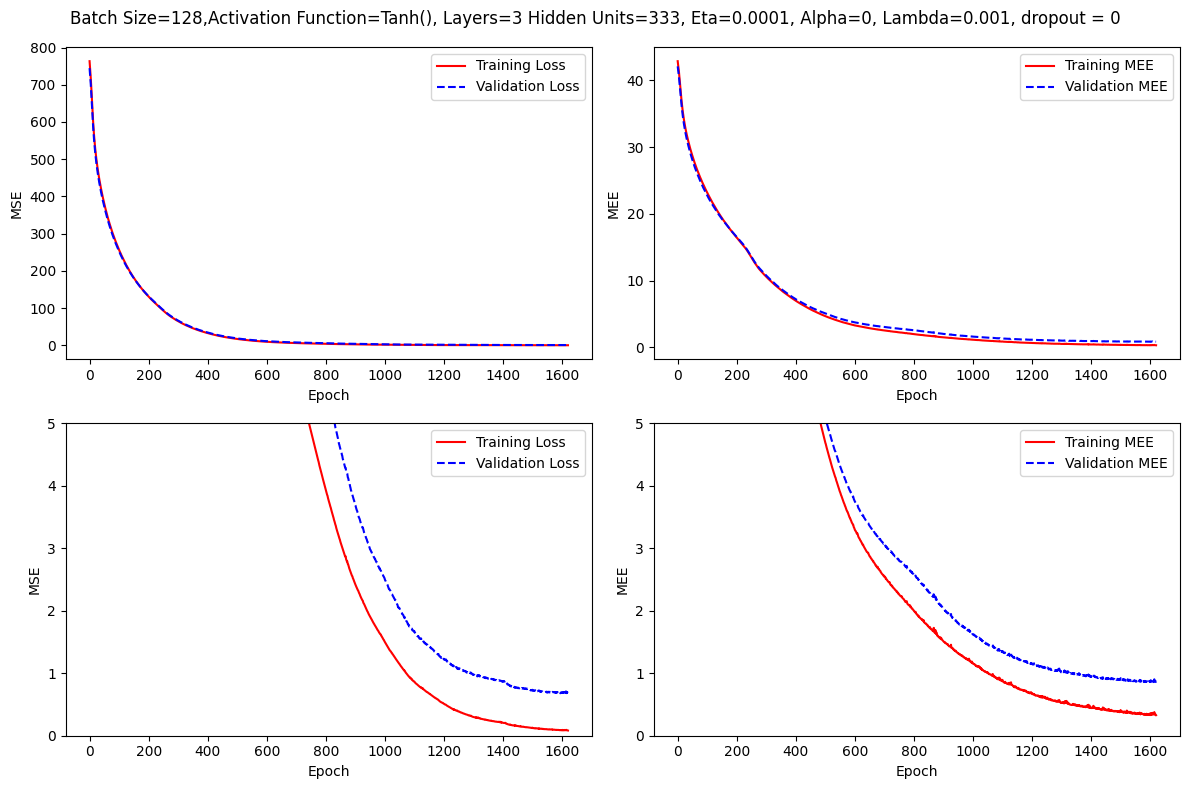

Avg of 1 initializations: Loss (train | test/val )= (0.08341 +- 0.0 | 0.6943 +- 0.0)- MEE (train | test/val ) = ( 0.3289 +-  0.0 | 0.8647 +- 0.0)
N. Epochs = 1523 - Loss (train | test/val )= (0.1379 | 0.4948 ) - MEE (train | test/val ) = (0.37 | 0.8377 )MEE: 0.8377     


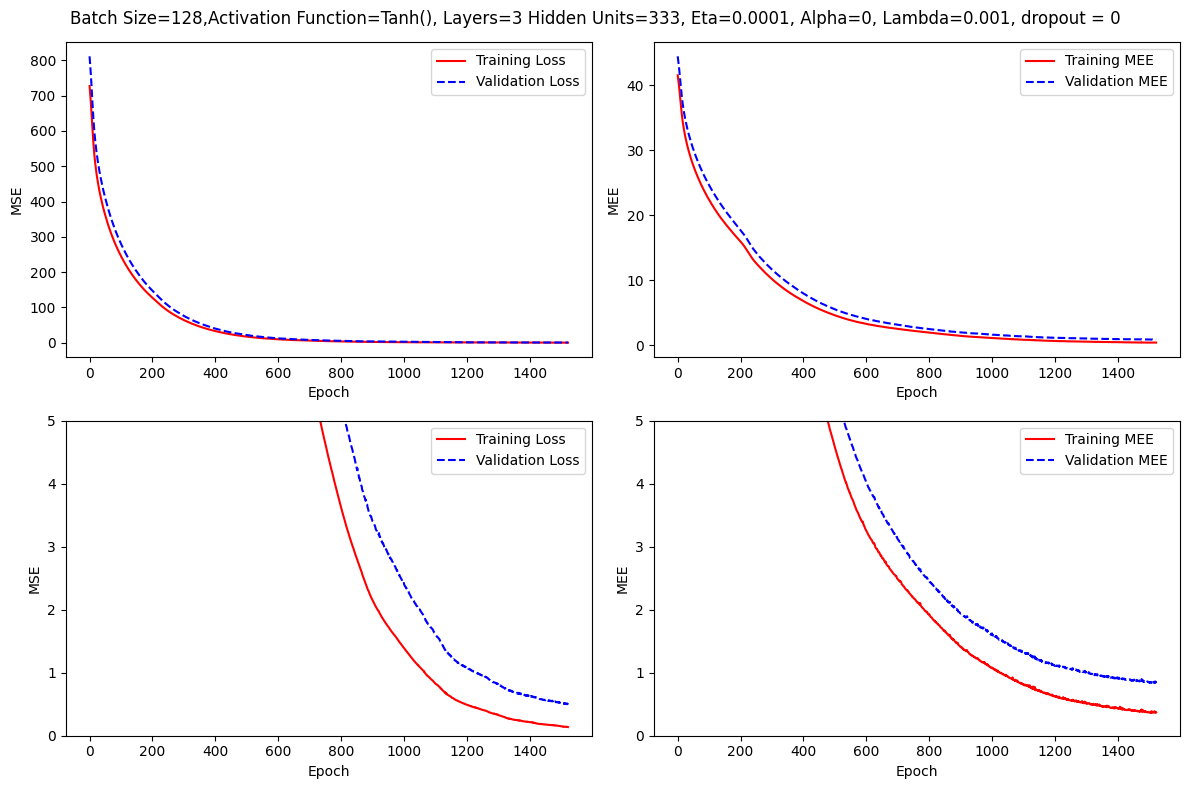

Avg of 1 initializations: Loss (train | test/val )= (0.1379 +- 0.0 | 0.4948 +- 0.0)- MEE (train | test/val ) = ( 0.37 +-  0.0 | 0.8377 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.09434 +- 0.03203 | val_loss = 0.4888 +- 0.1703train_mee = 0.344 +- 0.01847 | val_mee = 0.7667 +- 0.12
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.7;lr_patience=5
Epoch 01113: reducing learning rate of group 0 to 7.0000e-05..9481 | Test - Epoch [1113/5000], Loss: 0.7623 MEE: 1.0250     
Epoch 01277: reducing learning rate of group 0 to 4.9000e-05.7128 | Test - Epoch [1277/5000], Loss: 0.5168 MEE: 0.8557 
Epoch 01341: reducing learning rate of group 0 to 3.4300e-05. 0.5323, MEE: 0.6533 | Test - Epoch [1341/5000], Loss: 0.4710 MEE: 0.8024 
Epoch 01351: reducing learning rate of group 0 to 2.4010e-05.: 0.5254, MEE: 0.6493 | Test - 

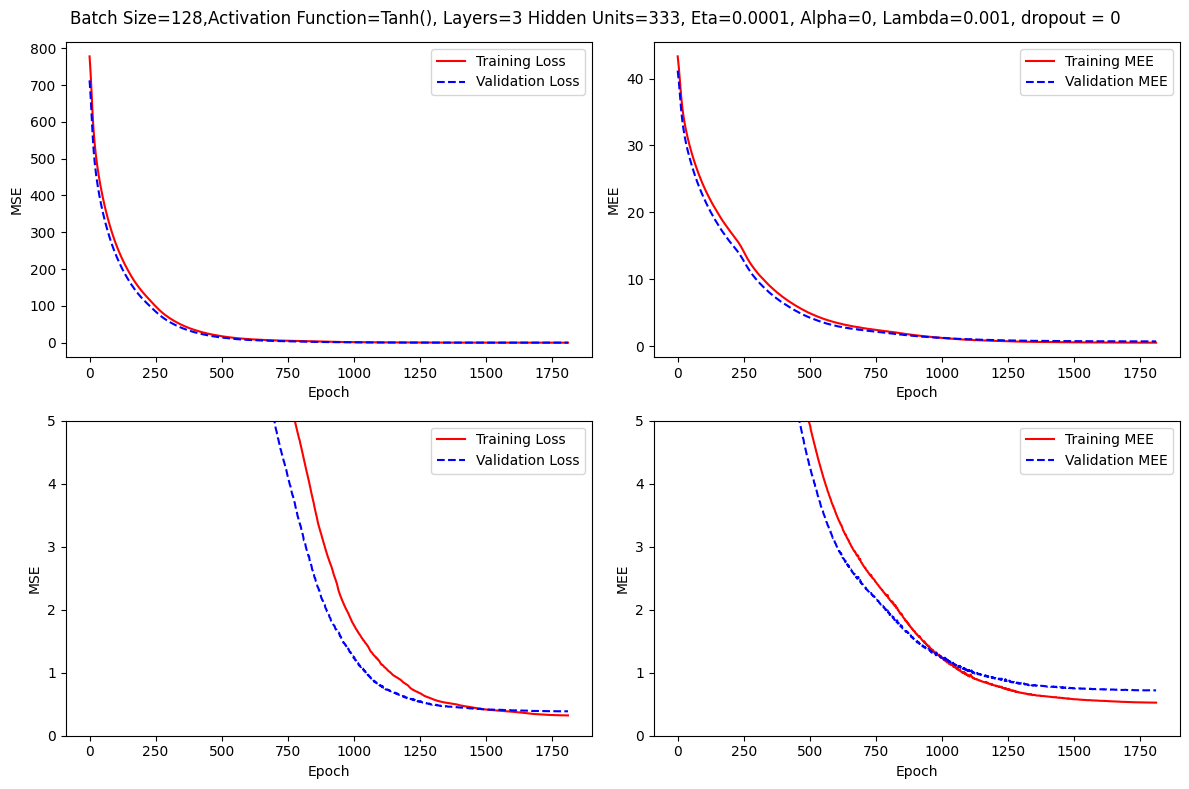

Avg of 1 initializations: Loss (train | test/val )= (0.3223 +- 0.0 | 0.3876 +- 0.0)- MEE (train | test/val ) = ( 0.5252 +-  0.0 | 0.7195 +- 0.0)
Epoch 01064: reducing learning rate of group 0 to 7.0000e-05..0253 | Test - Epoch [1064/5000], Loss: 2.4813 MEE: 1.5060     
Epoch 01074: reducing learning rate of group 0 to 4.9000e-05.0108 | Test - Epoch [1074/5000], Loss: 2.4450 MEE: 1.4782 
Epoch 01134: reducing learning rate of group 0 to 3.4300e-05. 1.2798, MEE: 0.9407 | Test - Epoch [1134/5000], Loss: 2.2943 MEE: 1.4102 
Epoch 01533: reducing learning rate of group 0 to 2.4010e-05.: 0.5070, MEE: 0.6413 | Test - Epoch [1533/5000], Loss: 1.2385 MEE: 1.0987 
Epoch 01871: reducing learning rate of group 0 to 1.6807e-05.: 0.1980, MEE: 0.4572 | Test - Epoch [1871/5000], Loss: 0.7301 MEE: 0.9080 
Epoch 01895: reducing learning rate of group 0 to 1.1765e-05.: 0.1888, MEE: 0.4494 | Test - Epoch [1895/5000], Loss: 0.7168 MEE: 0.9026 
Epoch 01937: reducing learning rate of group 0 to 8.2354e-06.: 

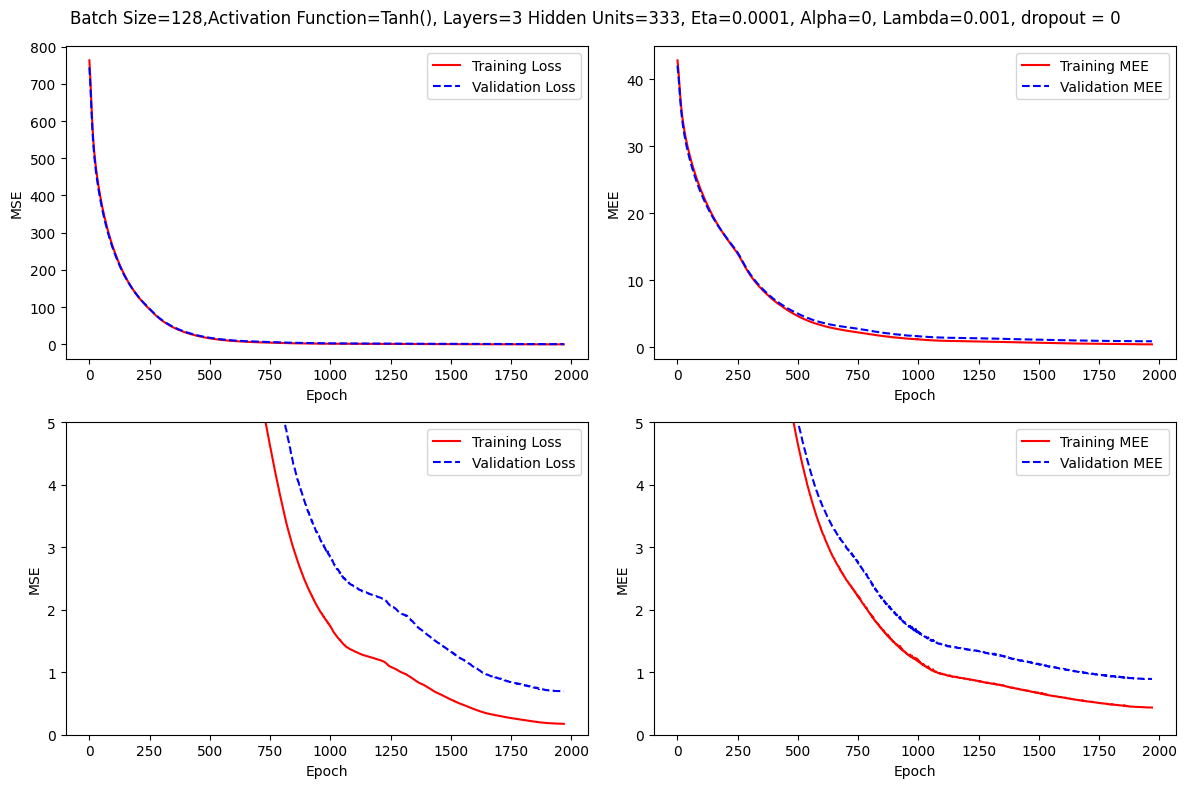

Avg of 1 initializations: Loss (train | test/val )= (0.1747 +- 0.0 | 0.6952 +- 0.0)- MEE (train | test/val ) = ( 0.4359 +-  0.0 | 0.8917 +- 0.0)
Epoch 01029: reducing learning rate of group 0 to 7.0000e-05..0169 | Test - Epoch [1029/5000], Loss: 2.0415 MEE: 1.5185     
Epoch 01314: reducing learning rate of group 0 to 4.9000e-05.5986 | Test - Epoch [1314/5000], Loss: 1.0484 MEE: 1.0975 
Epoch 01362: reducing learning rate of group 0 to 3.4300e-05. 0.3809, MEE: 0.5506 | Test - Epoch [1362/5000], Loss: 0.9560 MEE: 1.0525 
Epoch 01467: reducing learning rate of group 0 to 2.4010e-05.: 0.3154, MEE: 0.5029 | Test - Epoch [1467/5000], Loss: 0.8364 MEE: 0.9995 
Epoch 01588: reducing learning rate of group 0 to 1.6807e-05.: 0.2708, MEE: 0.4694 | Test - Epoch [1588/5000], Loss: 0.7603 MEE: 0.9670 
Epoch 01611: reducing learning rate of group 0 to 1.1765e-05.: 0.2641, MEE: 0.4635 | Test - Epoch [1611/5000], Loss: 0.7503 MEE: 0.9582 
Epoch 01653: reducing learning rate of group 0 to 8.2354e-06.: 

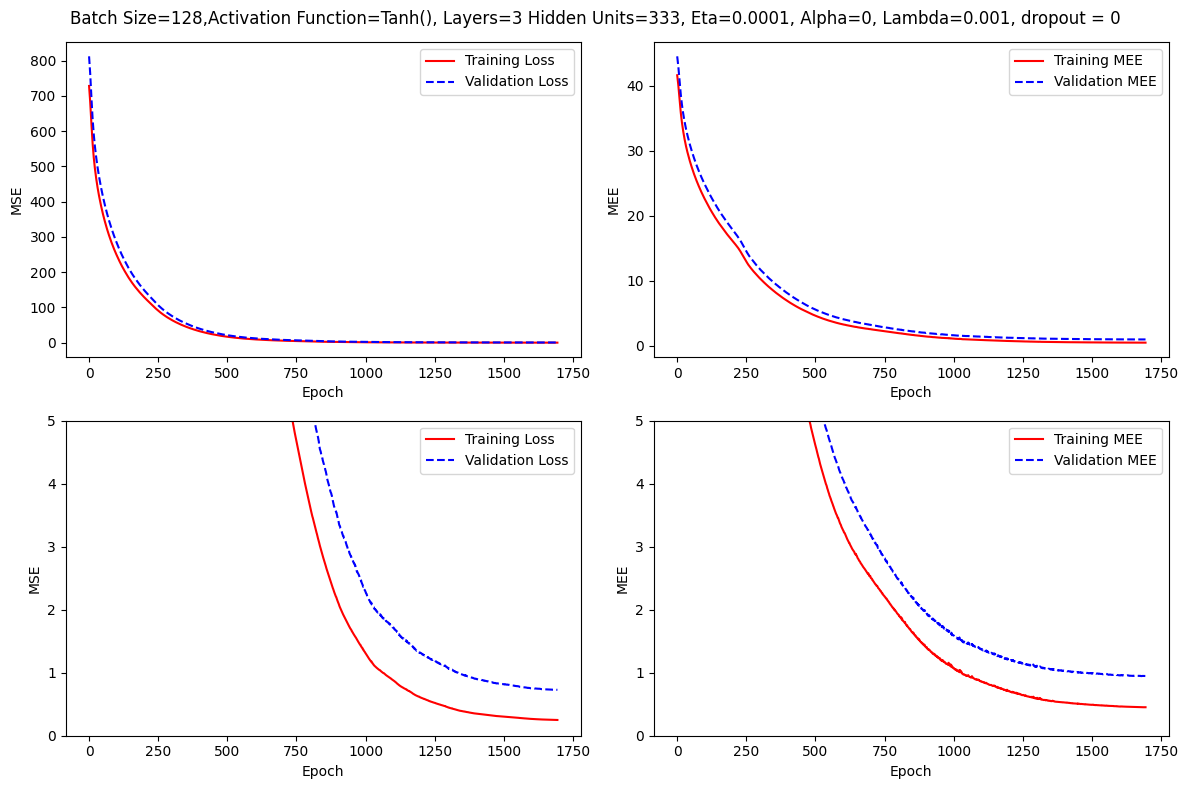

Avg of 1 initializations: Loss (train | test/val )= (0.25 +- 0.0 | 0.7286 +- 0.0)- MEE (train | test/val ) = ( 0.4523 +-  0.0 | 0.9481 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.249 +- 0.06024 | val_loss = 0.6038 +- 0.1535train_mee = 0.4711 +- 0.03881 | val_mee = 0.8531 +- 0.09725
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.7;lr_patience=10
Epoch 01570: reducing learning rate of group 0 to 7.0000e-05..3794 | Test - Epoch [1570/5000], Loss: 0.2952 MEE: 0.6230     
Epoch 01643: reducing learning rate of group 0 to 4.9000e-05.3602 | Test - Epoch [1643/5000], Loss: 0.2965 MEE: 0.6193 
N. Epochs = 1731 - Loss (train | test/val )= (0.07297 | 0.2922 ) - MEE (train | test/val ) = (0.3219 | 0.5998 )oss: 0.2922 MEE: 0.5998 


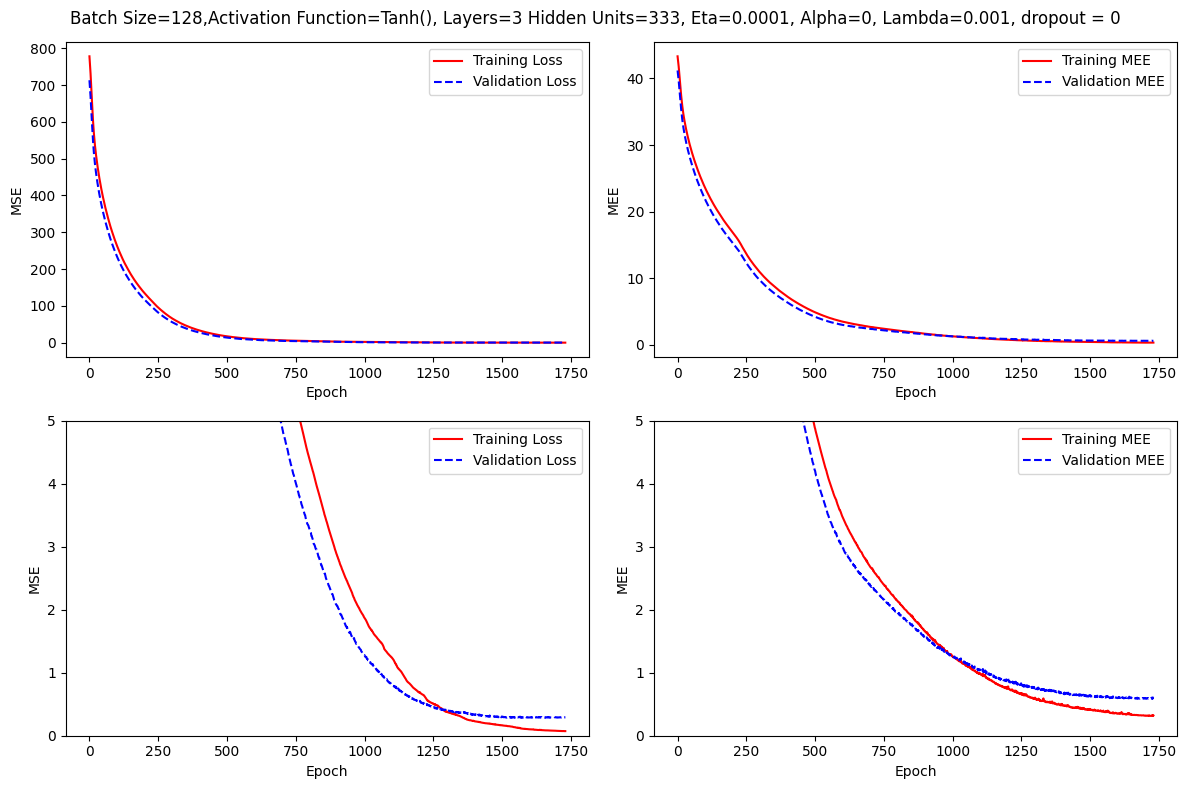

Avg of 1 initializations: Loss (train | test/val )= (0.07297 +- 0.0 | 0.2922 +- 0.0)- MEE (train | test/val ) = ( 0.3219 +-  0.0 | 0.5998 +- 0.0)
Epoch 01443: reducing learning rate of group 0 to 7.0000e-05..4244 | Test - Epoch [1443/5000], Loss: 0.7151 MEE: 0.8940     
Epoch 01463: reducing learning rate of group 0 to 4.9000e-05.4130 | Test - Epoch [1463/5000], Loss: 0.7106 MEE: 0.8969 
Epoch 01541: reducing learning rate of group 0 to 3.4300e-05. 0.1251, MEE: 0.3824 | Test - Epoch [1541/5000], Loss: 0.6778 MEE: 0.8741 
Epoch 01607: reducing learning rate of group 0 to 2.4010e-05.: 0.1102, MEE: 0.3592 | Test - Epoch [1607/5000], Loss: 0.6608 MEE: 0.8615 
Epoch 01703: reducing learning rate of group 0 to 1.6807e-05.: 0.0984, MEE: 0.3452 | Test - Epoch [1703/5000], Loss: 0.6538 MEE: 0.8592 
Epoch 01797: reducing learning rate of group 0 to 1.1765e-05.: 0.0906, MEE: 0.3334 | Test - Epoch [1797/5000], Loss: 0.6446 MEE: 0.8515 
N. Epochs = 1845 - Loss (train | test/val )= (0.08798 | 0.6417

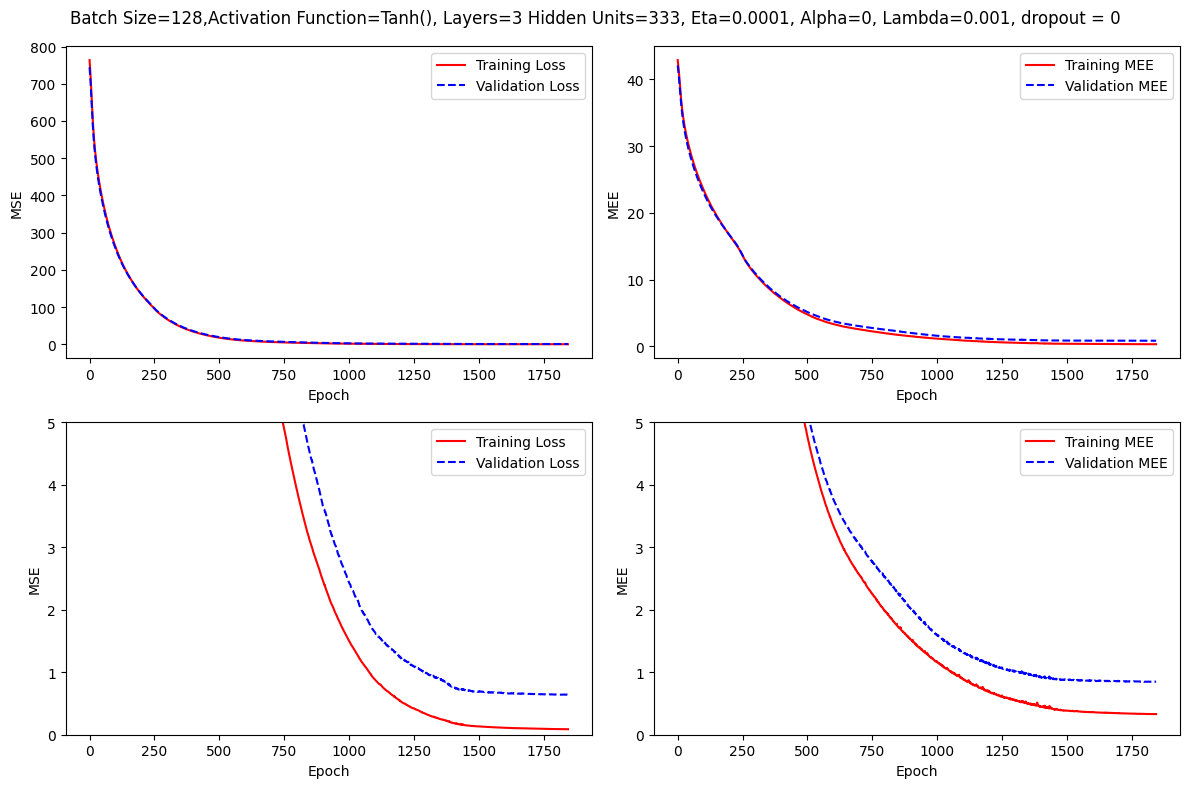

Avg of 1 initializations: Loss (train | test/val )= (0.08798 +- 0.0 | 0.6417 +- 0.0)- MEE (train | test/val ) = ( 0.3303 +-  0.0 | 0.8522 +- 0.0)
Epoch 01410: reducing learning rate of group 0 to 7.0000e-05..4377 | Test - Epoch [1410/5000], Loss: 0.8474 MEE: 0.9825     
Epoch 01681: reducing learning rate of group 0 to 4.9000e-05.3396 | Test - Epoch [1681/5000], Loss: 0.5976 MEE: 0.8676 
Epoch 01712: reducing learning rate of group 0 to 3.4300e-05. 0.1225, MEE: 0.3195 | Test - Epoch [1712/5000], Loss: 0.5828 MEE: 0.8608 
Epoch 01776: reducing learning rate of group 0 to 2.4010e-05.: 0.1105, MEE: 0.3111 | Test - Epoch [1776/5000], Loss: 0.5602 MEE: 0.8454 
N. Epochs = 1831 - Loss (train | test/val )= (0.1052 | 0.548 ) - MEE (train | test/val ) = (0.3015 | 0.8345 ), Loss: 0.5480 MEE: 0.8345 


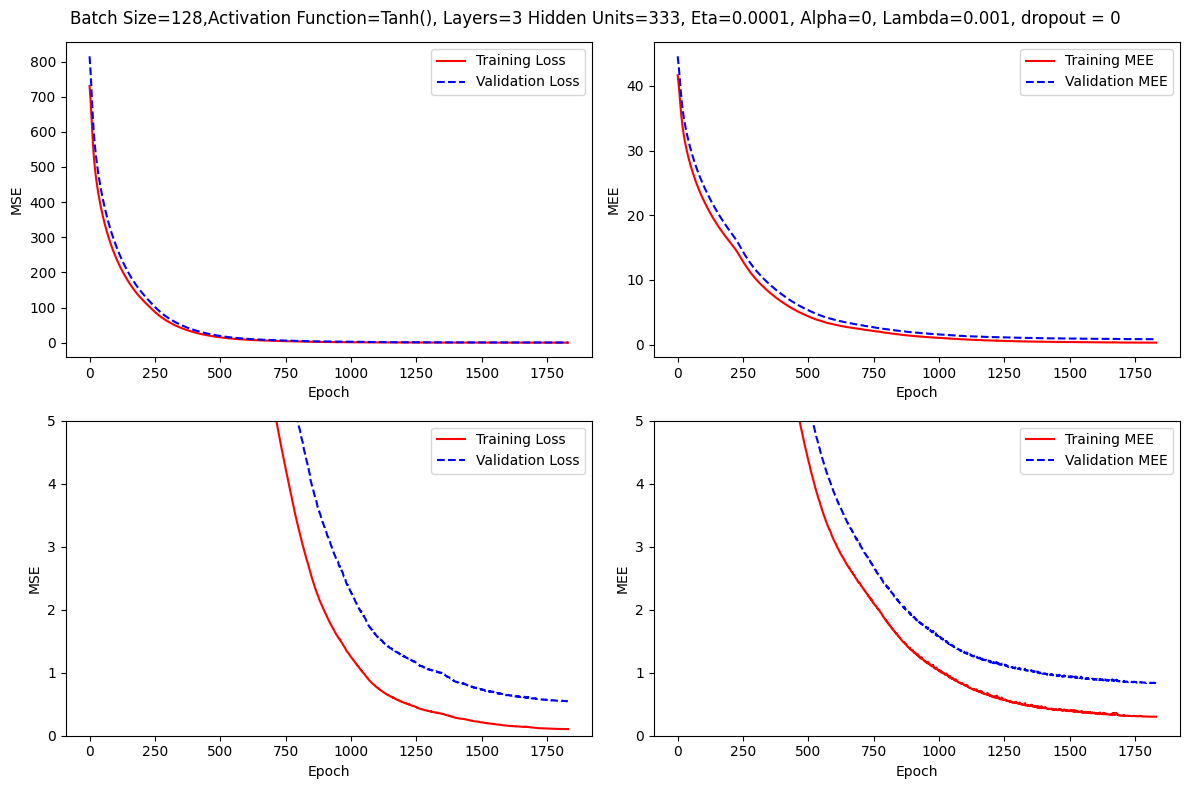

Avg of 1 initializations: Loss (train | test/val )= (0.1052 +- 0.0 | 0.548 +- 0.0)- MEE (train | test/val ) = ( 0.3015 +-  0.0 | 0.8345 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.08872 +- 0.01317 | val_loss = 0.494 +- 0.1477train_mee = 0.3179 +- 0.0121 | val_mee = 0.7622 +- 0.1151
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.7;lr_patience=20
N. Epochs = 1718 - Loss (train | test/val )= (0.07124 | 0.2872 ) - MEE (train | test/val ) = (0.3184 | 0.5977 ): 0.5977     


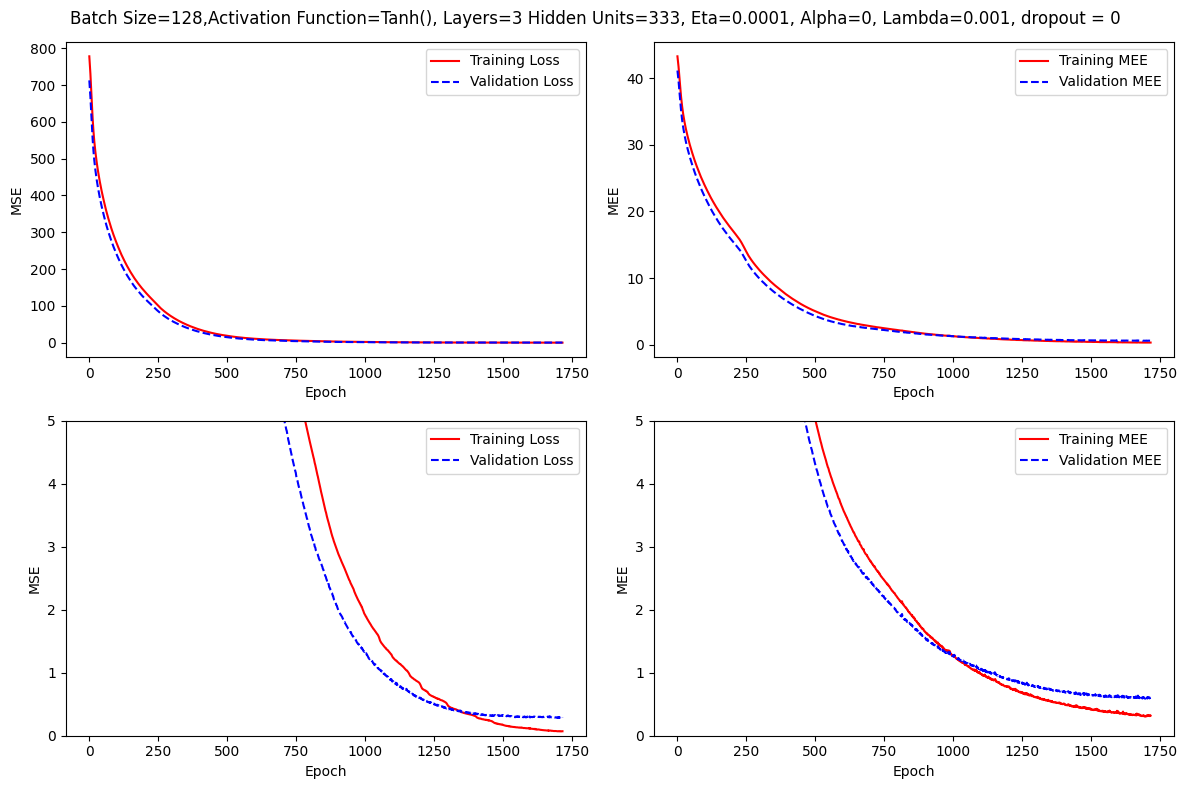

Avg of 1 initializations: Loss (train | test/val )= (0.07124 +- 0.0 | 0.2872 +- 0.0)- MEE (train | test/val ) = ( 0.3184 +-  0.0 | 0.5977 +- 0.0)
N. Epochs = 1642 - Loss (train | test/val )= (0.09745 | 0.5124 ) - MEE (train | test/val ) = (0.3404 | 0.7659 ): 0.7659     


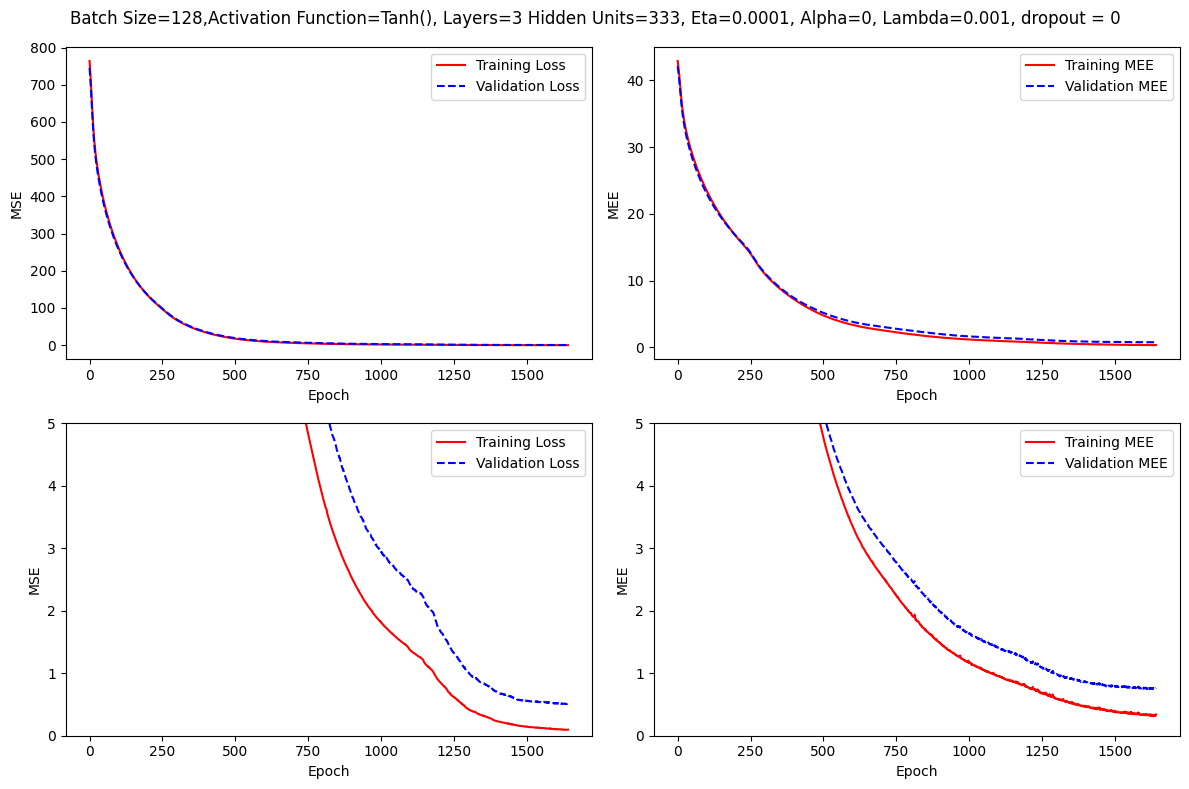

Avg of 1 initializations: Loss (train | test/val )= (0.09745 +- 0.0 | 0.5124 +- 0.0)- MEE (train | test/val ) = ( 0.3404 +-  0.0 | 0.7659 +- 0.0)
N. Epochs = 1670 - Loss (train | test/val )= (0.09606 | 0.4335 ) - MEE (train | test/val ) = (0.3186 | 0.7929 ): 0.7929     


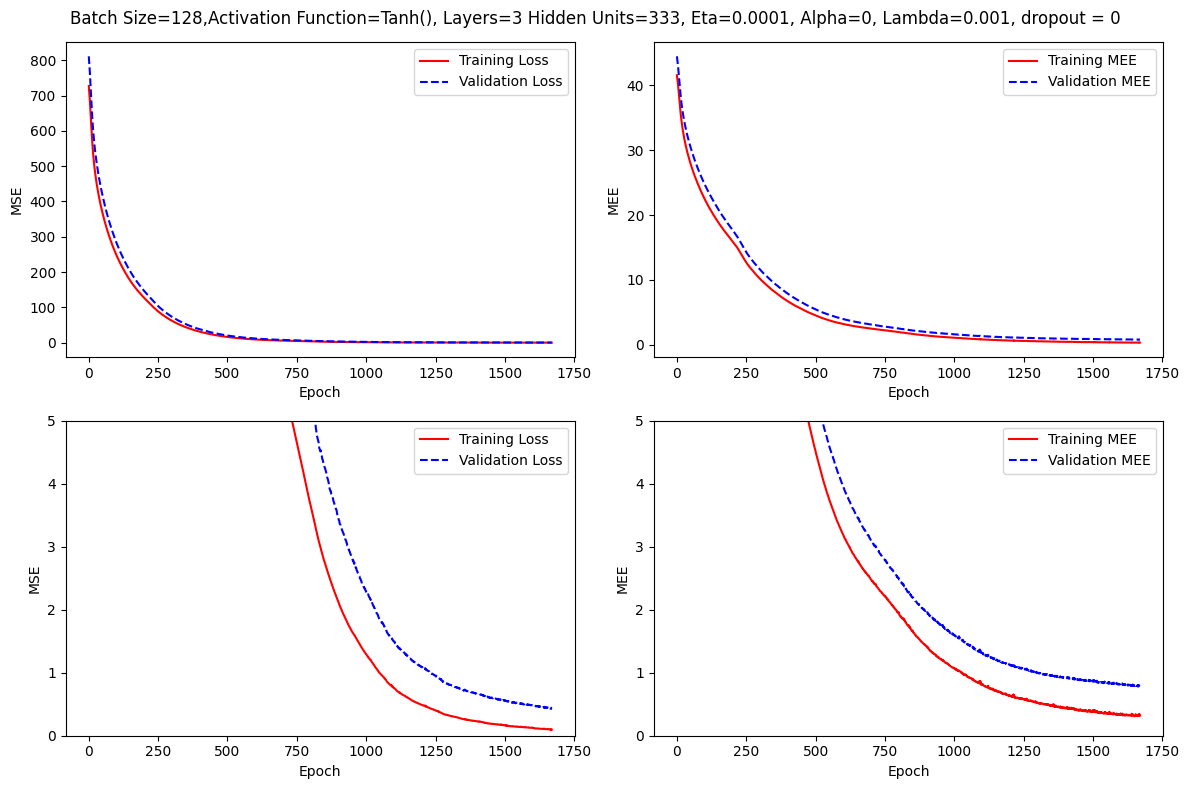

Avg of 1 initializations: Loss (train | test/val )= (0.09606 +- 0.0 | 0.4335 +- 0.0)- MEE (train | test/val ) = ( 0.3186 +-  0.0 | 0.7929 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.08825 +- 0.01204 | val_loss = 0.411 +- 0.09329train_mee = 0.3258 +- 0.01035 | val_mee = 0.7188 +- 0.08634
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.7;lr_patience=50
N. Epochs = 1728 - Loss (train | test/val )= (0.05825 | 0.2342 ) - MEE (train | test/val ) = (0.3173 | 0.5791 ): 0.5791     


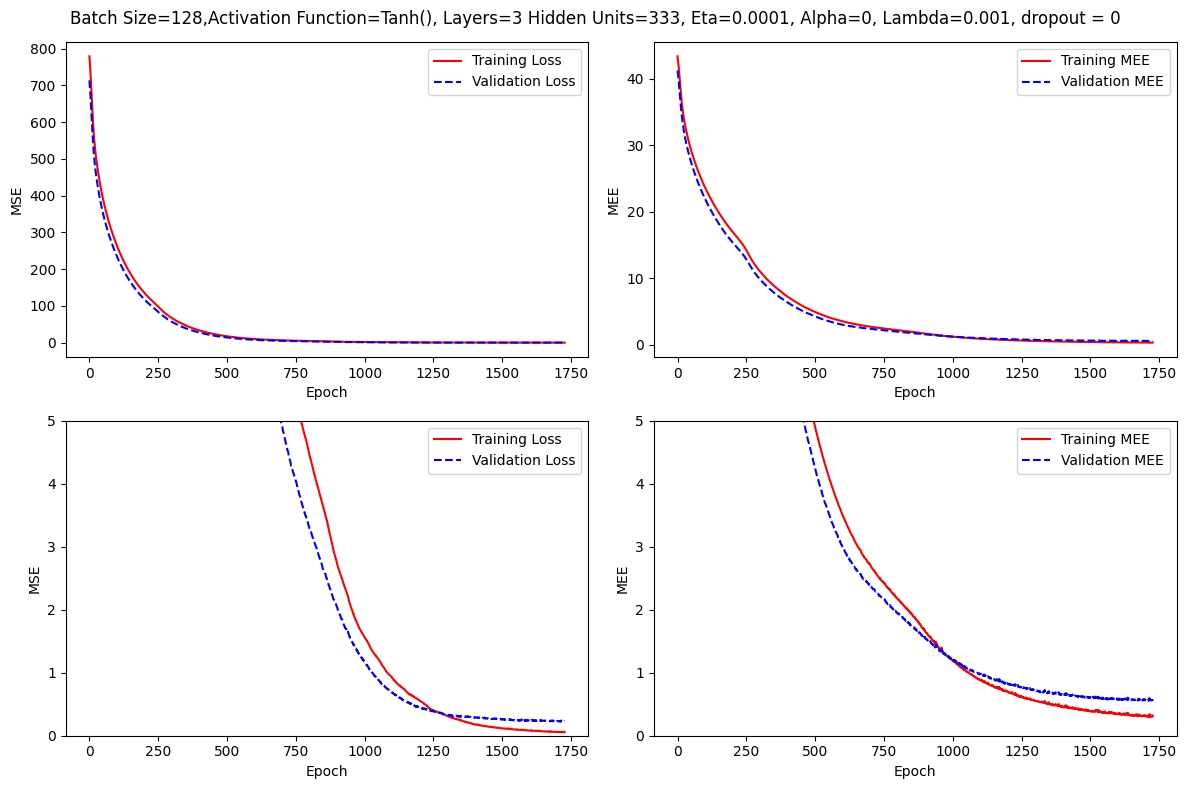

Avg of 1 initializations: Loss (train | test/val )= (0.05825 +- 0.0 | 0.2342 +- 0.0)- MEE (train | test/val ) = ( 0.3173 +-  0.0 | 0.5791 +- 0.0)
N. Epochs = 1607 - Loss (train | test/val )= (0.09896 | 0.5598 ) - MEE (train | test/val ) = (0.3455 | 0.8158 ): 0.8158     


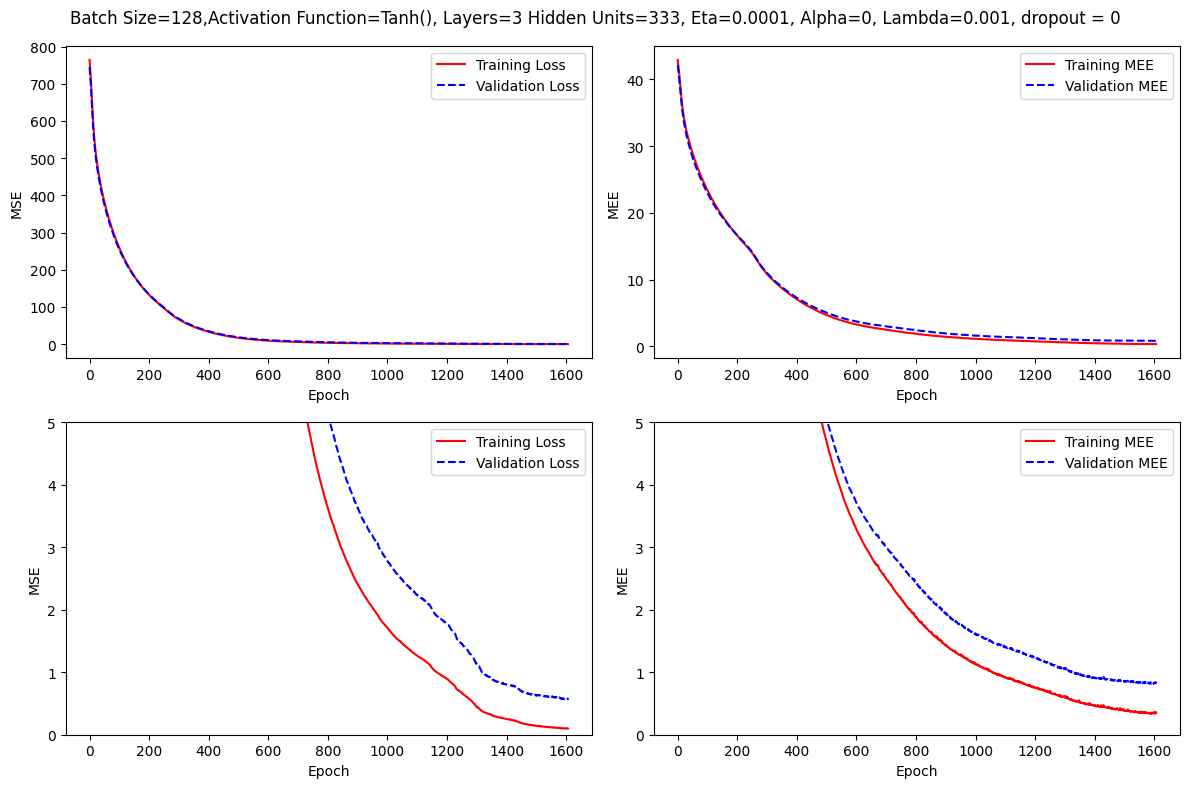

Avg of 1 initializations: Loss (train | test/val )= (0.09896 +- 0.0 | 0.5598 +- 0.0)- MEE (train | test/val ) = ( 0.3455 +-  0.0 | 0.8158 +- 0.0)
N. Epochs = 1669 - Loss (train | test/val )= (0.08808 | 0.4546 ) - MEE (train | test/val ) = (0.3151 | 0.8019 ): 0.8019     


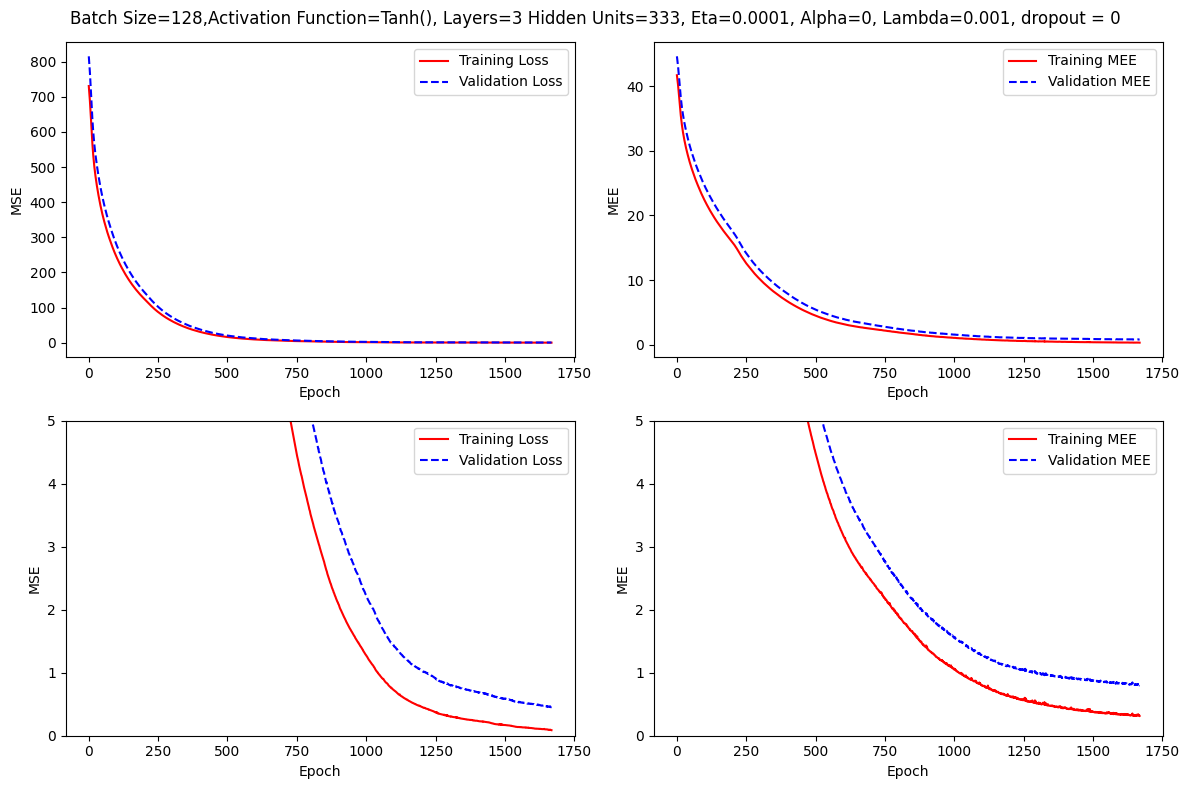

Avg of 1 initializations: Loss (train | test/val )= (0.08808 +- 0.0 | 0.4546 +- 0.0)- MEE (train | test/val ) = ( 0.3151 +-  0.0 | 0.8019 +- 0.0)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001 --> train_loss = 0.08176 +- 0.01721 | val_loss = 0.4162 +- 0.1357train_mee = 0.326 +- 0.01384 | val_mee = 0.7323 +- 0.1085
activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; factor=0.9;lr_patience=5
Epoch 01175: reducing learning rate of group 0 to 9.0000e-05..7832 | Test - Epoch [1175/5000], Loss: 0.5486 MEE: 0.9032     
Epoch 01230: reducing learning rate of group 0 to 8.1000e-05.7039 | Test - Epoch [1230/5000], Loss: 0.4663 MEE: 0.8358 
Epoch 01277: reducing learning rate of group 0 to 7.2900e-05.0.6334 | Test - Epoch [1277/5000], Loss: 0.4132 MEE: 0.7868 
Epoch 01334: reducing learning rate of group 0 to 6.5610e-05. 0.3593, MEE: 0.5795 | Test - Epoch [133

In [101]:
'''
#study of the effect of activation function
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh(),nn.ReLU()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
#study of the effect of regularization
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-2,1e-3,1e-4,1e-5]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''



'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0.5,0.8] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.7,0.8,0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'
'''


hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4,2e-4]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'
#[1250, 0.0001, 0, 128, 0.001, Tanh(), 3, 0] n Best val MEE: 0.9019991093211703
factors = [0.5,0.7,0.9]
lr_patiences = [5,10,20,50]

best_hp = perform_grid_search_kfold(hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    factors,
                                    lr_patiences,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    number_of_init=1,
                                    plot_curves=True)

# TRAIN THE FINAL MODEL ON ALL THE TRAINING SET

Epoch 00667: reducing learning rate of group 0 to 5.0000e-05.8440 | Test - Epoch [667/5000], Loss: 1.3828 MEE: 1.1288       
Epoch 00945: reducing learning rate of group 0 to 2.5000e-05.895 | Test - Epoch [945/5000], Loss: 0.7839 MEE: 0.8297 
Epoch 01021: reducing learning rate of group 0 to 1.2500e-05.0.4570 | Test - Epoch [1021/5000], Loss: 0.7412 MEE: 0.8029 
Epoch 01150: reducing learning rate of group 0 to 6.2500e-06. 0.4222 | Test - Epoch [1150/5000], Loss: 0.6976 MEE: 0.7753 
Epoch 01210: reducing learning rate of group 0 to 3.1250e-06. 0.4131 | Test - Epoch [1210/5000], Loss: 0.6792 MEE: 0.7606 
Epoch 01355: reducing learning rate of group 0 to 1.5625e-06.: 0.4028 | Test - Epoch [1355/5000], Loss: 0.6640 MEE: 0.7544 
Epoch 01379: reducing learning rate of group 0 to 7.8125e-07.E: 0.4018 | Test - Epoch [1379/5000], Loss: 0.6619 MEE: 0.7533 
N. Epochs = 1383 - Loss (train | test/val )= (0.1354 | 0.662 ) - MEE (train | test/val ) = (0.4015 | 0.7533 )20 MEE: 0.7533 
Epoch 00821: re

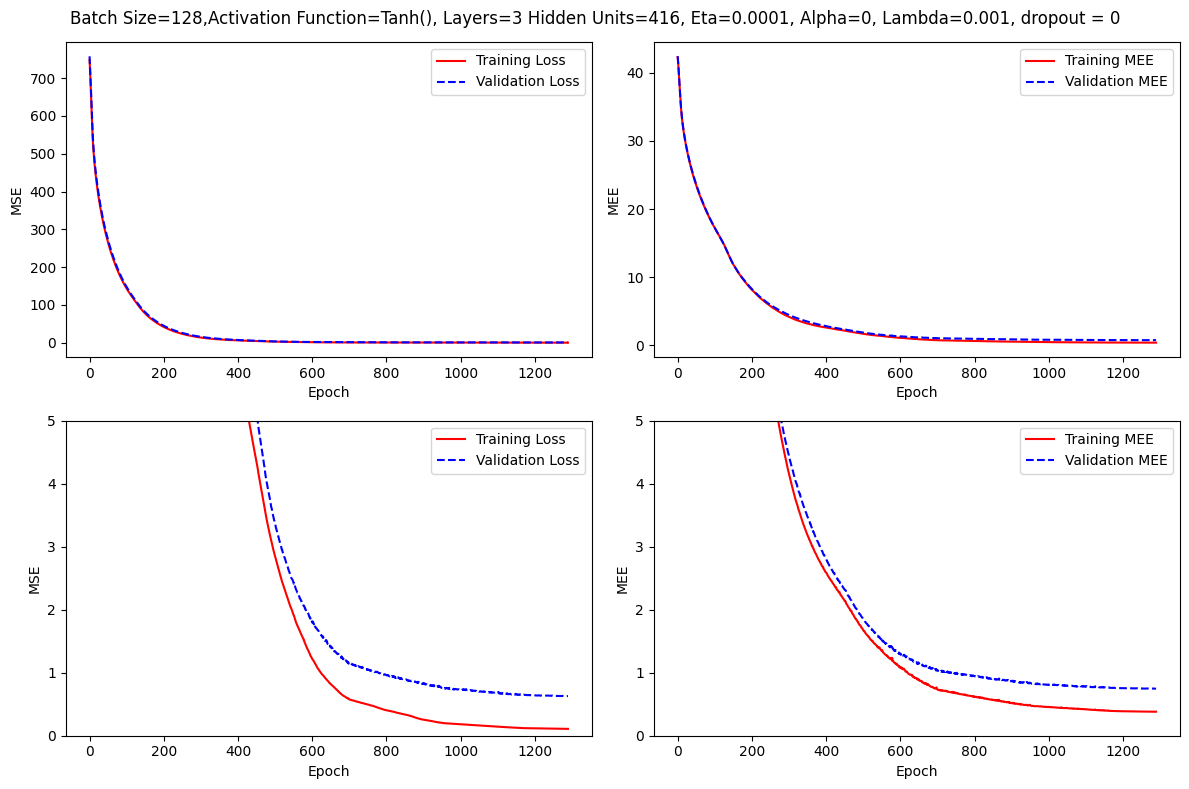

Avg of 5 initializations: Loss (train | test/val )= (0.1536 +- 0.05236 | 0.7263 +- 0.09845)- MEE (train | test/val ) = ( 0.4071 +-  0.03044 | 0.7806 +- 0.03641)


In [ ]:
models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = train_with_different_initializations(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               neuron_number=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               activation= best_hp[5],
               layers= best_hp[6],
               dropout= best_hp[7],
               optimiz=optimiz,
               max_num_epochs=5000,
               plot_curves=True,
               return_history=True,
               N=5)

#save models to file
for index, model in enumerate(models):
    torch.save(model,f'saved_models/trained_nn{index}.pth')

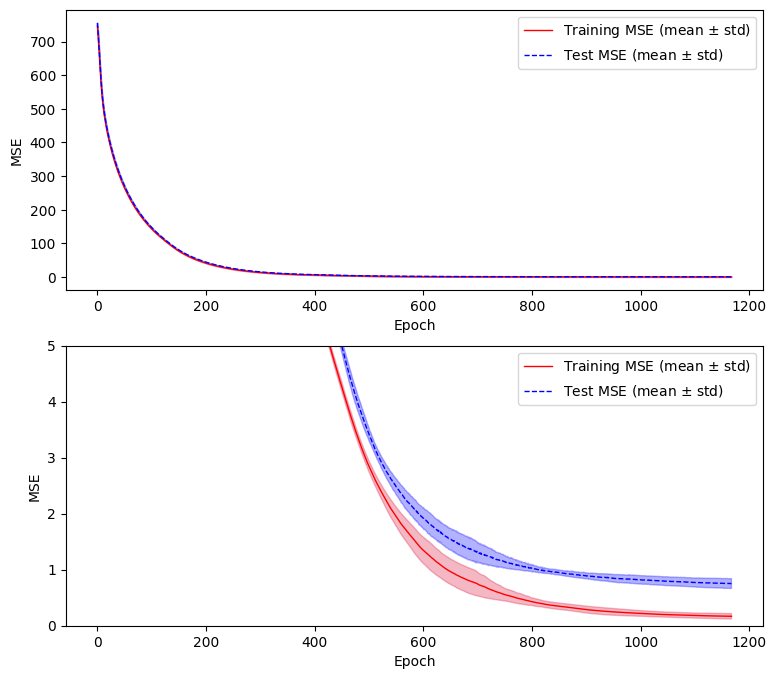

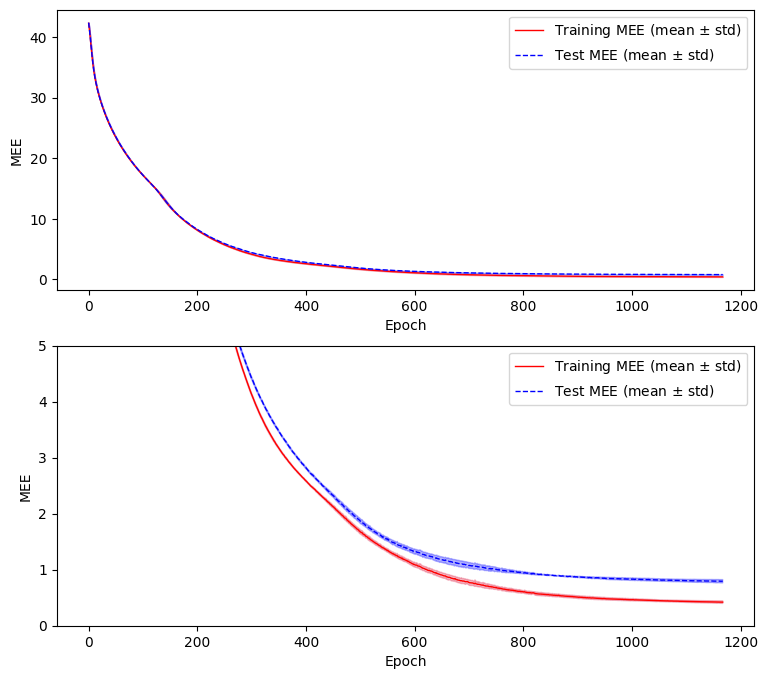

In [ ]:
plot_mean_std(N=5,train_hist=train_losses_hist,test_hist=test_losses_hist,label='MSE')
plot_mean_std(N=5,train_hist=train_mees_hist,test_hist=test_mees_hist,label='MEE')

# COMMITTEE RESPONSE

In [ ]:
#save models to file
for index, model in enumerate(models):
    torch.save(model,f'saved_models/trained_nn{index}.pth')

In [ ]:
def committee(model_name, N):
    model0 = torch.load(f'saved_models/{model_name}0.pth')
    model0.eval()
    output_sum = model0(X_test)
    #print(output_sum[0])

    for i in range(1,N):
        model = torch.load(f'saved_models/{model_name}{i}.pth')
        model.eval()
        test_outputs = model(X_test)
        #print(test_outputs[0])
        output_sum += test_outputs
        #print(output_sum[0])

    return output_sum/N


output_commitee = committee('trained_nn', N=5)
print(output_commitee.shape)
# Calculate test mee
test_mee = mean_euclidean_error(output_commitee,y_test)
print(test_mee)

torch.Size([200, 3])
0.7542089819908142
